In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import WeekdayLocator
from matplotlib.dates import DateFormatter
from matplotlib.dates import MO
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

df = pd.read_csv('data.csv')

# Data Transformation

In [3]:
df['CAMPAIGN'] = df['CAMPAIGN'].fillna('Other')
df['DATE'] = pd.to_datetime(df['DATE'])

In [4]:
# Grouping the dataframe by ORDER_ID and transforming it into the desired structure efficiently
def aggregate_rows(series):
    return series.tolist()

# Grouping by ORDER_ID and applying the custom aggregation function to each column except for ORDER_ID
transformed_df = df.groupby('ORDER_ID').agg({col: aggregate_rows for col in df.columns if col != 'ORDER_ID'}).reset_index()

# Converting the grouped dataframe back to a dictionary format as requested
transformed_data_efficient = transformed_df.to_dict(orient='records')

# For demonstration, convert it to the format where each ORDER_ID is a key to its own dictionary
transformed_data_dict = {item['ORDER_ID']: {k: v for k, v in item.items() if k != 'ORDER_ID'} for item in transformed_data_efficient}


In [5]:
new_df = pd.DataFrame.from_dict(transformed_data_dict, orient='index') #10317883
new_df['Basket Revenue'] = new_df['Revenue'].apply(lambda x:np.sum(x))
new_df['RSC/VW'] = new_df.apply(lambda row: [a/b for a, b in zip(row['Real_SHC'], row['DESI'])],axis=1)
new_df['R/RSC'] = new_df.apply(lambda row: [a/b for a, b in zip(row['Revenue'], row['Real_SHC'])],axis=1)
# Calculate the sum of Real_SHC for each row and add it as a new column
new_df['Sum_Real_SHC'] = new_df['Real_SHC'].apply(sum)

# Calculate the sum of DESI for each row and add it as a new column
new_df['Sum_DESI'] = new_df['DESI'].apply(sum)

# Calculate the ratio of the sum of Real_SHC to the sum of DESI for each row and add it as a new column
# This includes handling for division by zero by using np.nan for rows where sum of DESI is 0
new_df['Sum_Real_SHC/Sum_DESI'] = new_df.apply(lambda row: row['Sum_Real_SHC'] / row['Sum_DESI'] if row['Sum_DESI'] != 0 else np.nan, axis=1)
new_df['Basket_Revenue/Sum_Real_SHC'] = new_df.apply(lambda row: row['Basket Revenue'] / row['Sum_Real_SHC'] if row['Sum_Real_SHC'] != 0 else np.nan, axis=1)

In [6]:
new_df

CARGO_ID  \
10000489                          [6]   
10000900                          [8]   
10001219                         [16]   
10001432                         [19]   
10001588                         [20]   
...                               ...   
99999806                    [2444490]   
99999841  [2444494, 2444494, 2444494]   
99999851                    [2444500]   
99999934                    [2444513]   
99999981                    [2444520]   

                                                       DATE  \
10000489                              [2017-04-25 00:00:00]   
10000900                              [2017-03-06 00:00:00]   
10001219                              [2017-04-26 00:00:00]   
10001432                              [2017-04-19 00:00:00]   
10001588                              [2017-04-22 00:00:00]   
...                                                     ...   
99999806                              [2017-03-01 00:00:00]   
99999841  [2017-03-12 00:00:00, 2017-03-12 00:00:00, 201...   
99999851                              [2017-03-13 00:00:00]   
99999934                              [2017-04-08 00:00:00]   
99999981                              [2017-04-03 00:00:00]   

                                                  SKU  \
10000489                              [TELAKLMIBAND2]   
10000900                              [HBV000001SXJP]   
10001219                              [HBV000001RJ34]   
10001432                              [EVUCZLKCLUCKY]   
10001588                          [TELAKLCASE4UU8SYH]   
...                                               ...   
99999806                               [PTTROPP14554]   
99999841  [ZYSAN914883, ZYKRISTAL259168, ZYGUR930225]   
99999851                            [ZYECZACI9470372]   
99999934                              [ZYPYON9998582]   
99999981                                  [PTDBM1290]   

                                               PRODUCT_NAME  \
10000489           [Xiaomi Mi Band 2 Akıllı Bileklik Siyah]   
10000900                                   [Sony Xperia XZ]   
10001219  [Sony Uch10 2.0A Hızlı Şarj Cihazı Seti Oem-Si...   
10001432                  [Fakir Lucky Elektirikli Süpürge]   
10001588  [Case 4U U8 Siyah iOS ve Android Uyumlu Akıllı...   
...                                                     ...   
99999806  [Champion Dana Etli Köpek Maması Çalışan ve Ak...   
99999841  [Sarelle Şekersiz Kakaolu Fındık Ezmesi 350 gr...   
99999851              [Uni Baby Çamaşır Yumuşatıcı 1500 ml]   
99999934  [Ariel Toz Çamaşır Deterjanı Dağ Esintisi 7 Kg...   
99999981        [Trixie köpek emniyet kemeri Small 30-60cm]   

                                               SUB_CATEGORY  \
10000489                                   [Akıllı Saatler]   
10000900                                     [Cep Telefonu]   
10001219                                   [Şarj Cihazları]   
10001432                                       [Süpürgeler]   
10001588                                   [Akıllı Saatler]   
...                                                     ...   
99999806                                     [Köpek Maması]   
99999841  [Gıda Ürünü, Organik ve Dogal Ürünler, Gıda Ür...   
99999851                 [Deterjan ve Temizlik Malzemeleri]   
99999934                 [Deterjan ve Temizlik Malzemeleri]   
99999981                           [Köpek Seyahat Ürünleri]   

           SUB_CATEGORY_CODE        QTY        Seller             DESI  \
10000489              [3407]        [2]          [PO]            [1.0]   
10000900                [60]        [1]          [PO]            [1.0]   
10001219               [534]        [1]          [MP]            [1.0]   
10001432               [736]        [1]          [PO]            [6.0]   
10001588              [3407]        [1]          [PO]            [1.0]   
...                      ...        ...           ...              ...   
99999806              [2696]        [1]          [MP]         

In [7]:
new_df.loc[10317883]

CARGO_ID                       [2890, 2890, 2890, 2890, 2890, 2890, 2892, 289...
DATE                           [2017-04-25 00:00:00, 2017-04-25 00:00:00, 201...
SKU                            [ZYULKER0762202, ZYPYON928148, ZYECZACI9300228...
PRODUCT_NAME                   [Komili Yuvam Peçete 100lü, Febreze Hava Ferah...
SUB_CATEGORY                   [Kağıt Ürünleri, Deterjan ve Temizlik Malzemel...
SUB_CATEGORY_CODE              [3045, 3507, 3507, 1719, 3310, 3507, 3320, 350...
QTY                            [2, 1, 2, 2, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
Seller                         [PO, PO, PO, PO, PO, PO, PO, PO, PO, PO, PO, P...
DESI                           [1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, ...
SHIPPING_COMPANY               [ARS, ARS, ARS, ARS, ARS, ARS, ARS, ARS, ARS, ...
CAMPAIGN                       [100 TL üzeri çatı, 100 TL üzeri çatı, 100 TL ...
FreeSH                         [False, False, False, False, False, False, Fal...
Weekend                     

# Basket Revenue (90th percentile)

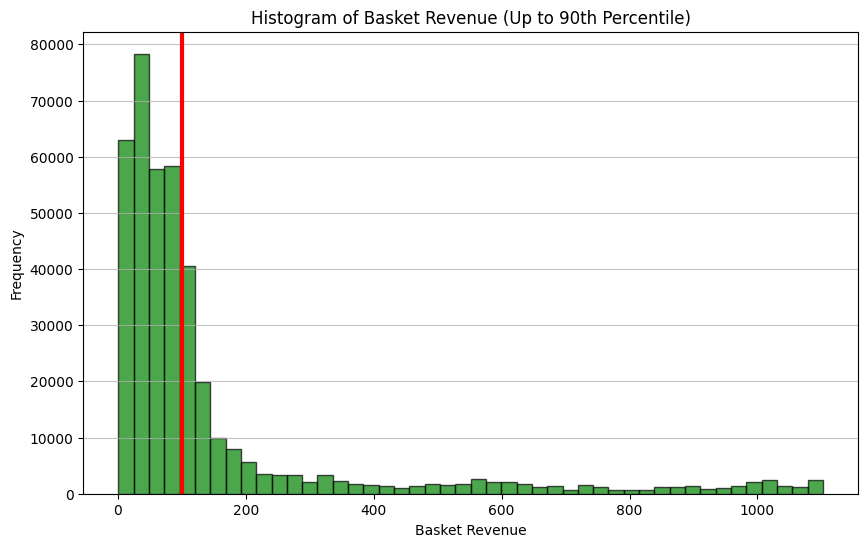

In [8]:
# Calculate the 0.90 percentile of the Basket Revenue to filter the data
percentile_90 = np.percentile(new_df['Basket Revenue'], 90)

# Filter the data to include only up to the 0.90 percentile
filtered_data = new_df[new_df['Basket Revenue'] <= percentile_90]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 90th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Baskets with "100TL üzeri çatı" campaign are rounded up to 100TL for baskets that have lower 'Basket Revenue' than 100TL

In [9]:
# Create a different subset based on the given conditions
subset_df = new_df.copy()

# Apply conditions: if 'CAMPAIGN' equals "100 TL üzeri çatı" in any items and 'Basket Revenue' < 100, set 'Basket Revenue' to 100
subset_df['Basket Revenue'] = subset_df.apply(
    lambda row: 100 if any(c == "100 TL üzeri çatı" for c in row['CAMPAIGN']) and row['Basket Revenue'] < 100 else row['Basket Revenue'],
    axis=1)

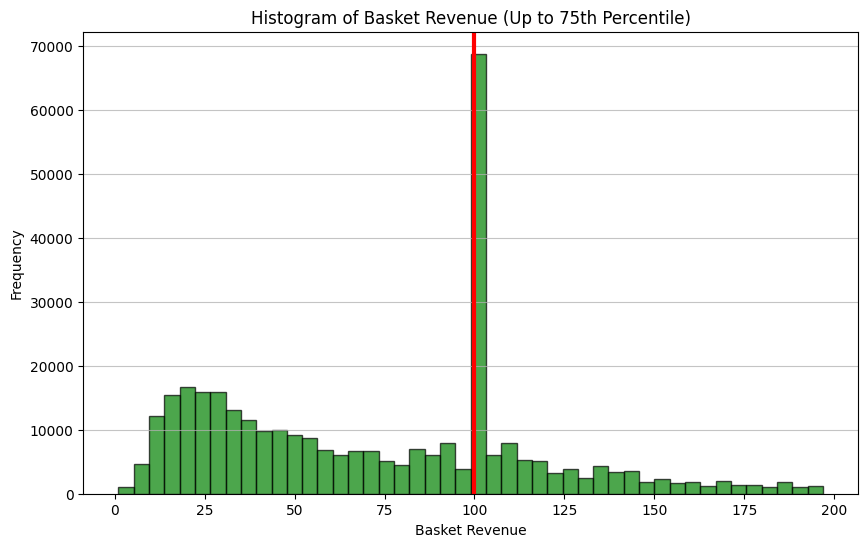

In [10]:
# Calculate the 0.75 percentile of the Basket Revenue to filter the data
percentile_75 = np.percentile(subset_df['Basket Revenue'], 75)

# Filter the data to include only up to the 0.90 percentile
filtered_data = subset_df[subset_df['Basket Revenue'] <= percentile_75]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 75th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Baskets with "100TL üzeri çatı" campaign with below 100TL 'Basket Revenue' are removed from the dataset (58270 baskets are removed)

In [11]:
# Adjusting approach to remove orders where 'CAMPAIGN' equals "100 TL üzeri çatı" and 'Basket Revenue' < 100

# Assuming 'new_df' has already been processed up to calculating 'Basket Revenue'
# and we have a column 'CAMPAIGN' that lists campaigns for each 'ORDER_ID'

# Define a function to check the condition and flag rows for removal
def should_remove_order(row):
    campaign_condition = any("100 TL üzeri çatı" in campaign for campaign in row['CAMPAIGN'])
    revenue_condition = row['Basket Revenue'] < 100
    return campaign_condition and revenue_condition

# Apply the function and add a 'Remove Order' flag to the dataframe
new_df['Remove Order'] = new_df.apply(should_remove_order, axis=1)

# Filter out the rows flagged for removal
filtered_df = new_df[~new_df['Remove Order']]

# Drop the 'Remove Order' column as it's no longer needed
filtered_df = filtered_df.drop(columns=['Remove Order'])

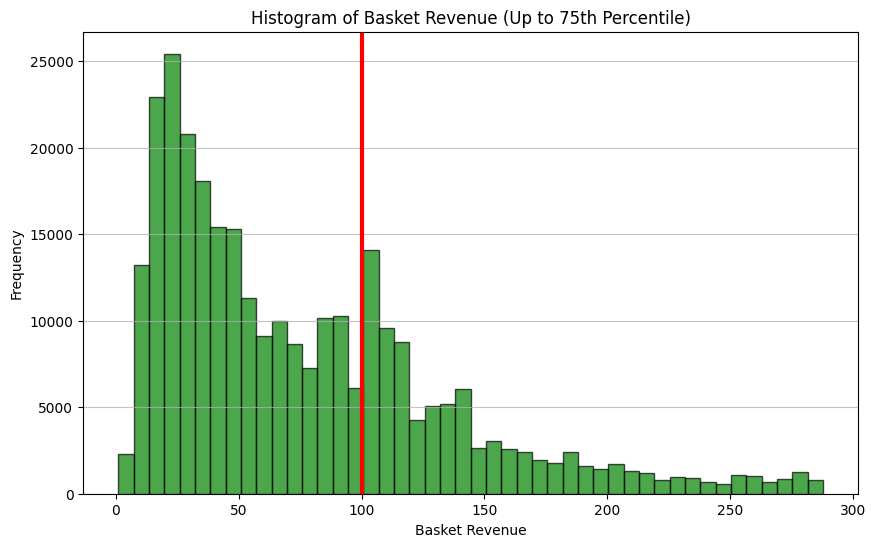

In [12]:
# Calculate the 0.75 percentile of the Basket Revenue to filter the data
percentile_75 = np.percentile(filtered_df['Basket Revenue'], 75)

# Filter the data to include only up to the 0.75 percentile
filtered_data = filtered_df[filtered_df['Basket Revenue'] <= percentile_75]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 75th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [13]:
#58270/105021 # of removed baskets / # of baskets with "100 TL üzeri çatı" campaign

# Same percentage of data is randomly removed from baskets (other than "100 TL üzeri çatı")  to protect the distribution of the initial data

In [14]:
# Correcting the approach without using sum for concatenation

# Separate into two subsets without causing a TypeError
sample_df = filtered_df.copy()
contains_campaign = sample_df[sample_df['CAMPAIGN'].apply(lambda x: "100 TL üzeri çatı" in x)]
does_not_contain_campaign = sample_df[sample_df['CAMPAIGN'].apply(lambda x: "100 TL üzeri çatı" not in x)]

# Randomly remove 55.5% of the rows from the subset without the campaign
rows_to_keep = does_not_contain_campaign.sample(frac=1-0.555, random_state=492)

# Merge the two subsets back together
merged_df = pd.concat([contains_campaign, rows_to_keep]).sort_index()

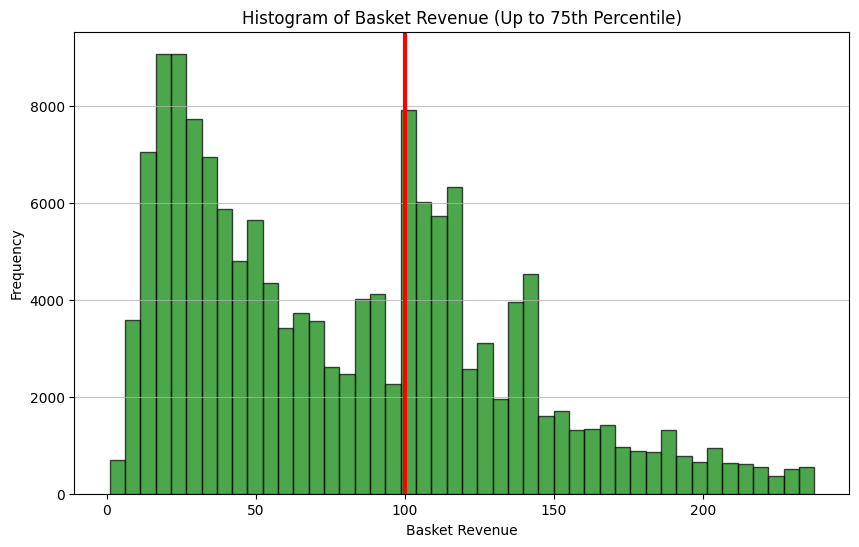

In [15]:
# Calculate the 0.75 percentile of the Basket Revenue to filter the data
percentile_75 = np.percentile(merged_df['Basket Revenue'], 75)

# Filter the data to include only up to the 0.75 percentile
filtered_data = merged_df[merged_df['Basket Revenue'] <= percentile_75]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 75th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

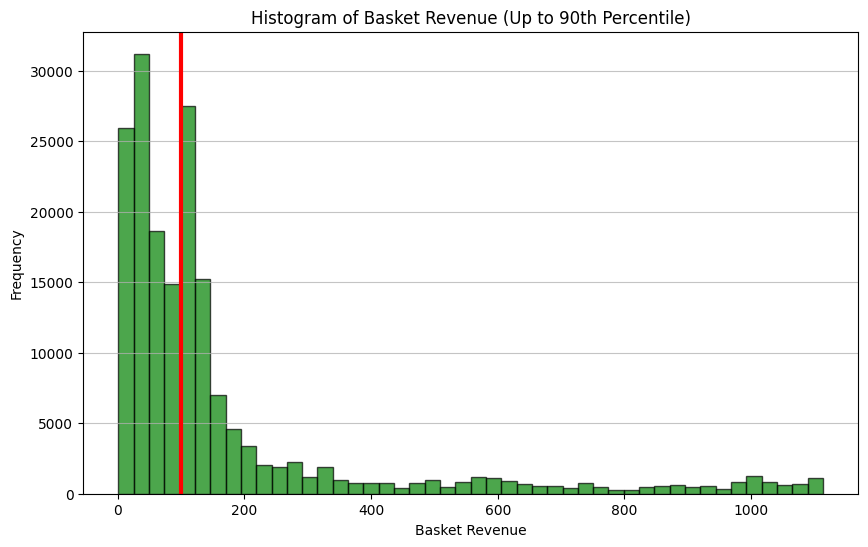

In [16]:
# Calculate the 0.90 percentile of the Basket Revenue to filter the data
percentile_90 = np.percentile(merged_df['Basket Revenue'], 90)

# Filter the data to include only up to the 0.75 percentile
filtered_data = merged_df[merged_df['Basket Revenue'] <= percentile_90]['Basket Revenue']

# Plotting the filtered Basket Revenue histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=46, color='green', alpha=0.7, edgecolor='black')
plt.title('Histogram of Basket Revenue (Up to 90th Percentile)')
plt.axvline(100, color='red', linewidth=3)
plt.xlabel('Basket Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Analyzing the effect of DESI on Real_SHC

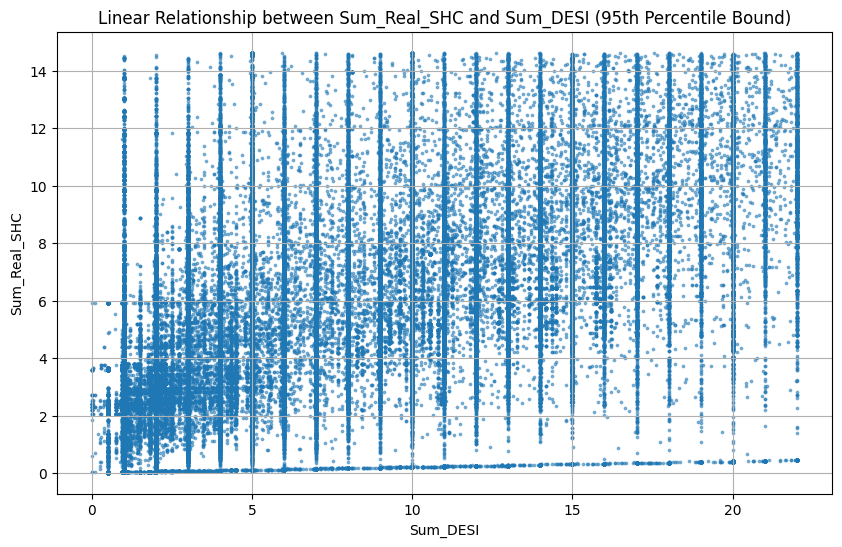

In [17]:
# Assuming new_df is the actual dataframe we want to work with, applying the percentile-based filtering

# Calculate the 95th percentile for both Sum_Real_SHC and Sum_DESI in the actual dataframe
upper_percentile_SHC_actual = new_df['Sum_Real_SHC'].quantile(0.95)
upper_percentile_DESI_actual = new_df['Sum_DESI'].quantile(0.95)

# Filter the actual dataframe to include only rows where both Sum_Real_SHC and Sum_DESI are below their respective 95th percentiles
filtered_df_percentile_actual = new_df[(new_df['Sum_Real_SHC'] <= upper_percentile_SHC_actual) & 
                                       (new_df['Sum_DESI'] <= upper_percentile_DESI_actual)]

# Plotting the filtered actual data without outliers above the 95th percentile
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df_percentile_actual['Sum_DESI'], filtered_df_percentile_actual['Sum_Real_SHC'], alpha=0.5, s=3)
plt.title('Linear Relationship between Sum_Real_SHC and Sum_DESI (95th Percentile Bound)')
plt.xlabel('Sum_DESI')
plt.ylabel('Sum_Real_SHC')
plt.grid(True)
plt.show()

In [18]:
correlation_coefficient = new_df['Sum_Real_SHC'].corr(new_df['Sum_DESI'])

# The Pearson correlation coefficient between Sum_Real_SHC and Sum_DESI is: 0.6938829633072248.

# ---------------------------------------------------------------------------------------------------------------

# Analyzing the Shipment Category of Baskets

In [171]:
real_free_shipping = 0
contingent_free_shipping = 0
paid_shipping = 0
mixed_shipping = 0

# Iterate through each row to check conditions
for index, row in new_df.iterrows():
    # Check if all elements in FreeSH are True and all elements in CFreeSH are False
    if all(row['FreeSH']) and not any(row['CFreeSH']):
        real_free_shipping += 1
    # Check if all elements in FreeSH are False and all elements in CFreeSH are True
    elif not any(row['FreeSH']) and all(row['CFreeSH']):
        contingent_free_shipping += 1
    # Check if all elements in FreeSH are False and all elements in CFreeSH are False
    elif not any(row['FreeSH']) and not any(row['CFreeSH']):
        paid_shipping += 1
    # Otherwise, consider it as mixed shipping
    else:
        mixed_shipping += 1

print(f"Real Free Shipping: {real_free_shipping}")
print(f"Contingent Free Shipping: {contingent_free_shipping}")
print(f"Paid Shipping: {paid_shipping}")
print(f"Mixed Shipping: {mixed_shipping}")


Real Free Shipping: 143577
Contingent Free Shipping: 91877
Paid Shipping: 192445
Mixed Shipping: 21241


In [172]:
# First, let's copy the DataFrame
df_copy = new_df.copy()

# Define a function that categorizes each row based on the conditions provided
def categorize_shipping(row):
    if all(row['FreeSH']) and not any(row['CFreeSH']):
        return 'real_free_shipping'
    elif not any(row['FreeSH']) and all(row['CFreeSH']):
        return 'contingent_free_shipping'
    elif not any(row['FreeSH']) and not any(row['CFreeSH']):
        return 'paid_shipping'
    else:
        return 'mixed_shipping'

# Apply the function to each row of the DataFrame and create a new column with the result
df_copy['Shipping_Category'] = df_copy.apply(categorize_shipping, axis=1)
# Apply the function to each row of the DataFrame to create the new column
new_df['Shipping_Category'] = new_df.apply(categorize_shipping, axis=1)

# Divide PO and MP

def categorize_basket(seller):
    unique_sellers = set(seller)
    if unique_sellers == {'PO'}:
        return 'PO Only'
    elif unique_sellers == {'MP'}:
        return 'MP Only'
    else:
        return 'Mixed'



# MO and MP Together

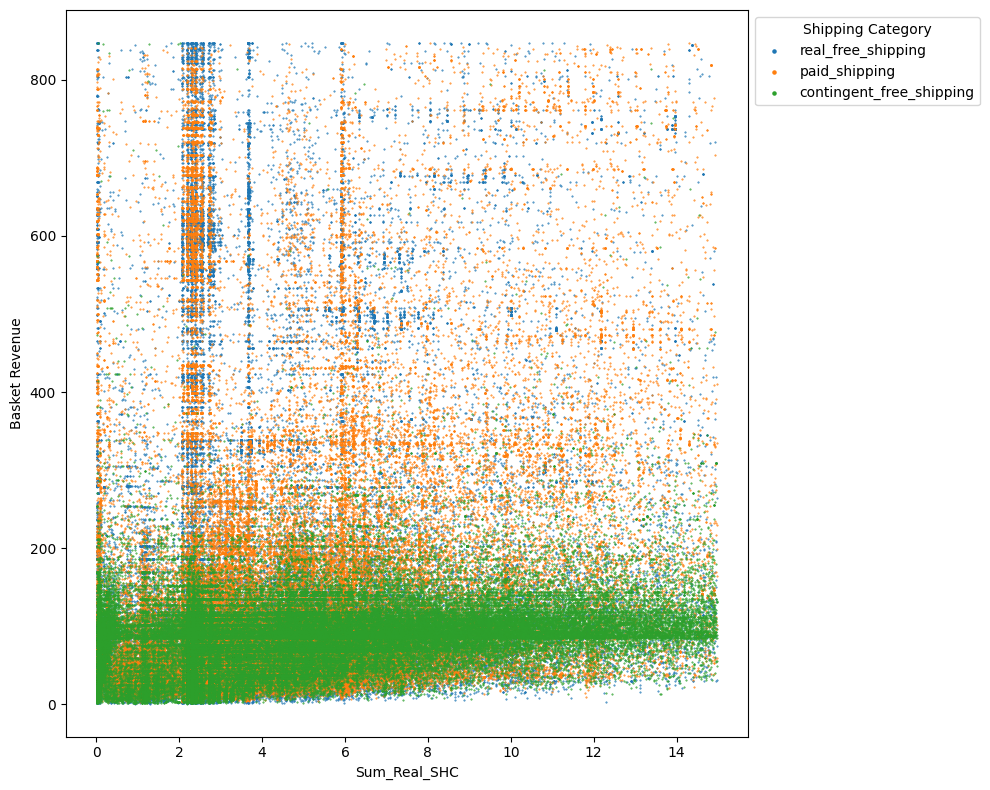

In [203]:
# Adjusting the quantile threshold
# Filter out transactions with only one sub-category item
transactions_with_multiple_items = new_df[new_df['SUB_CATEGORY'].apply(len) > 1]

pd.options.mode.copy_on_write = True
transactions_with_multiple_items['Provider'] = transactions_with_multiple_items['Seller'].apply(categorize_basket)
transactions_with_multiple_items_mp = transactions_with_multiple_items[transactions_with_multiple_items['Provider'] == 'MP Only']
transactions_with_multiple_items_po = transactions_with_multiple_items[transactions_with_multiple_items['Provider'] == 'PO Only']

quantile_sum_real_shc = transactions_with_multiple_items['Sum_Real_SHC'].quantile(0.9)
quantile_basket_revenue = transactions_with_multiple_items['Basket Revenue'].quantile(0.9)

# Filter out outliers
df_filtered = df_copy[(df_copy['Sum_Real_SHC'] <= quantile_sum_real_shc) &
                      (df_copy['Basket Revenue'] <= quantile_basket_revenue)]

# Exclude 'mixed_shipping' from the filtered DataFrame
df_filtered = df_filtered[df_filtered['Shipping_Category'] != 'mixed_shipping']

# Plotting with an enlarged figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

# Now 'categories' will only include categories present in 'df_filtered', excluding 'mixed_shipping'
categories = df_filtered['Shipping_Category'].unique()

for category in categories:
    subset = df_filtered[df_filtered['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=0.2)  # Dot size in the plot

ax.set_xlabel('Sum_Real_SHC')
ax.set_ylabel('Basket Revenue')
# Placing the legend outside the plot on the right, enlarging the dots only in the legend
ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)  # Increase markerscale as needed
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

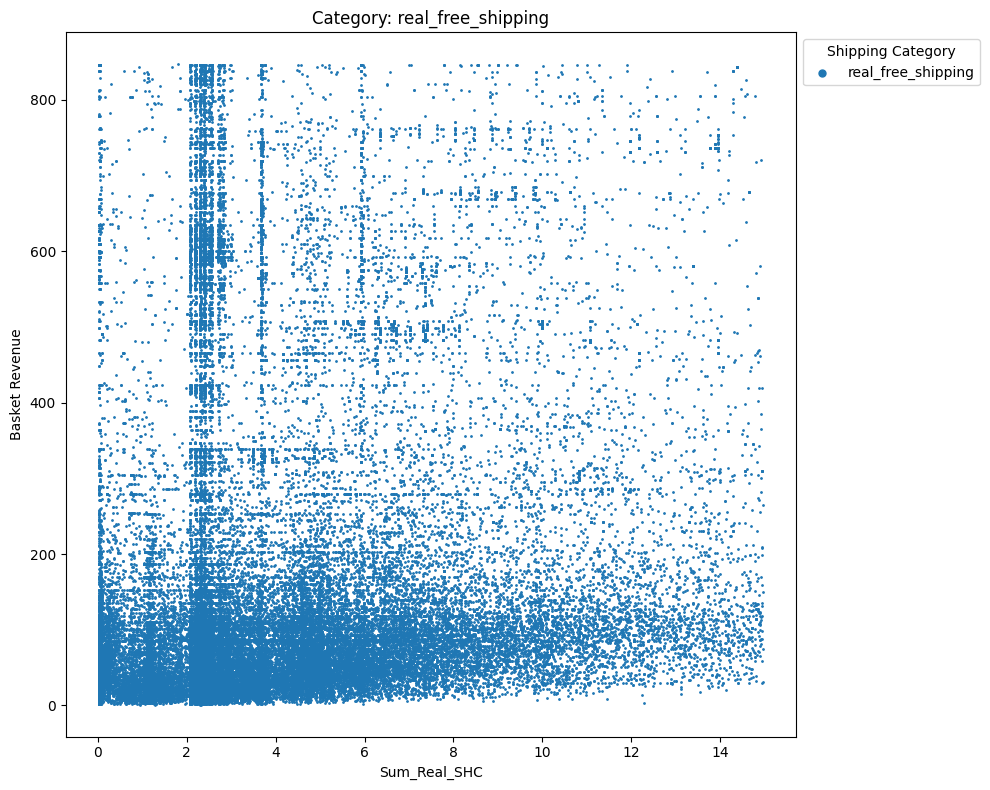

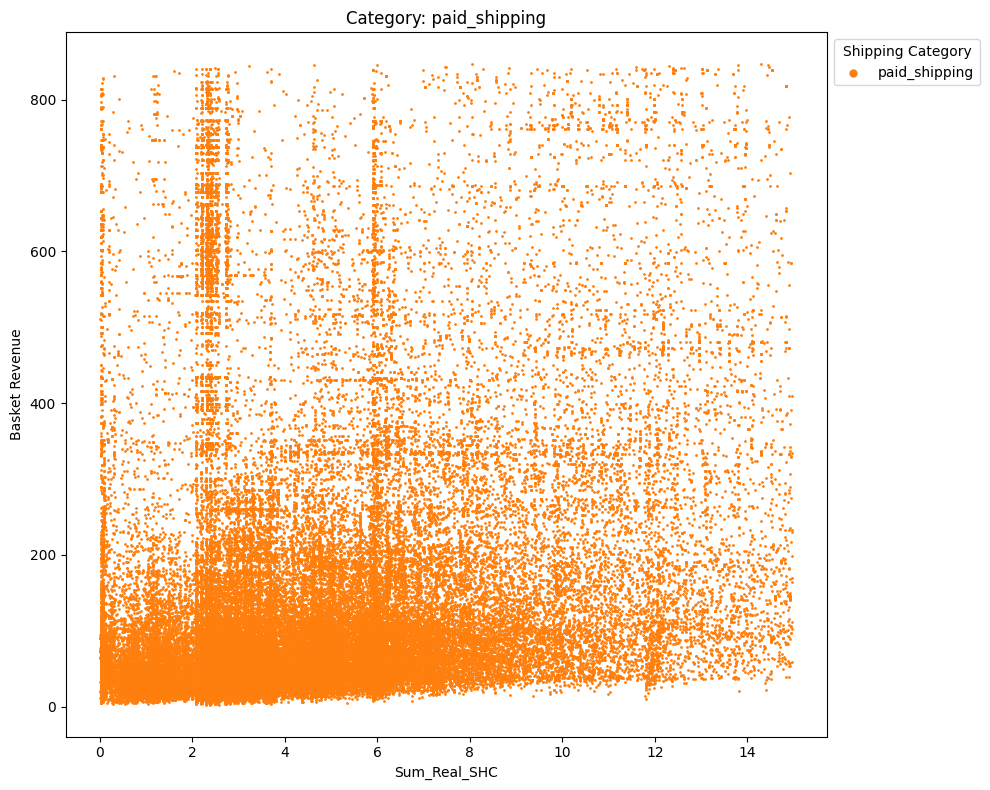

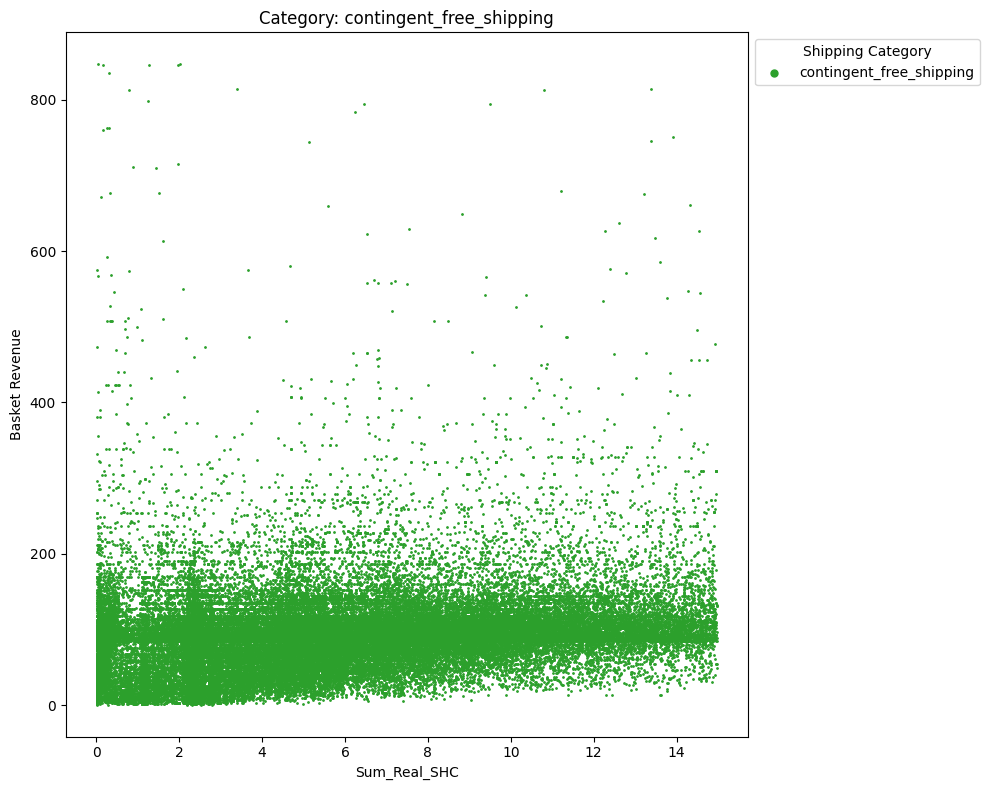

In [204]:
# Create a color map for consistent coloring across plots
categories = df_filtered['Shipping_Category'].unique()
color_map = {category: plt.cm.tab10(i) for i, category in enumerate(categories)}

# Plot separate graphs for each category using the color map
for category in categories:
    fig, ax = plt.subplots(figsize=(10, 8))
    subset = df_filtered[df_filtered['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=1, color=color_map[category])
    
    ax.set_xlabel('Sum_Real_SHC')
    ax.set_ylabel('Basket Revenue')
    ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)
    plt.title(f"Category: {category}")
    plt.tight_layout()
    plt.show()

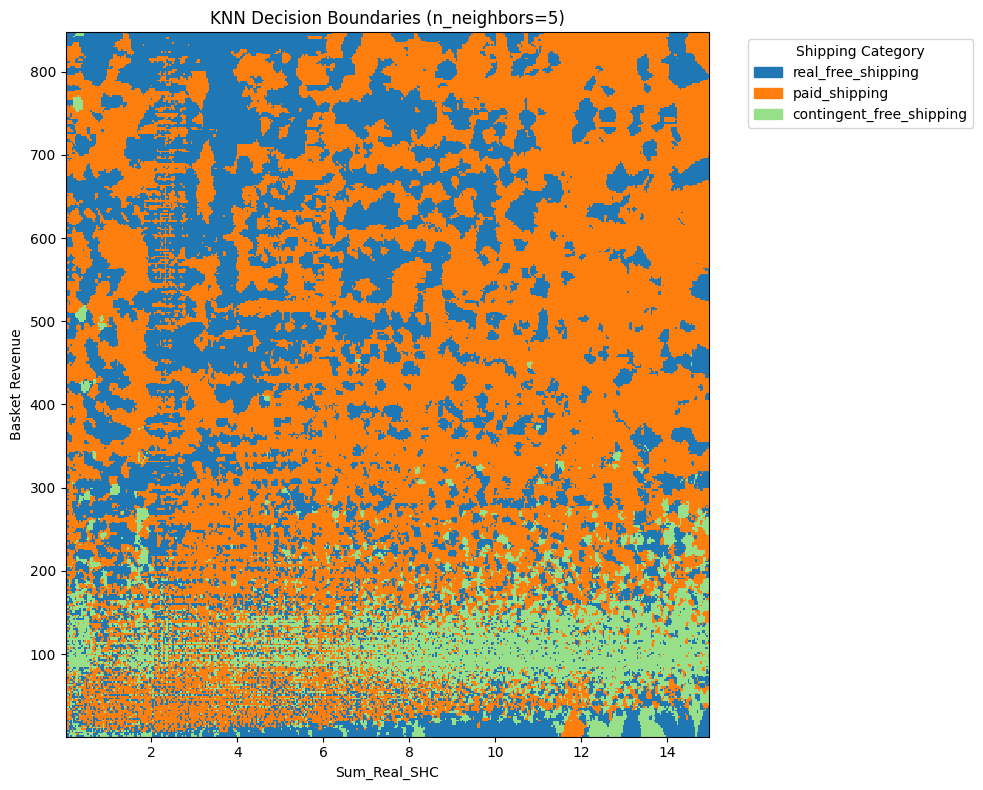

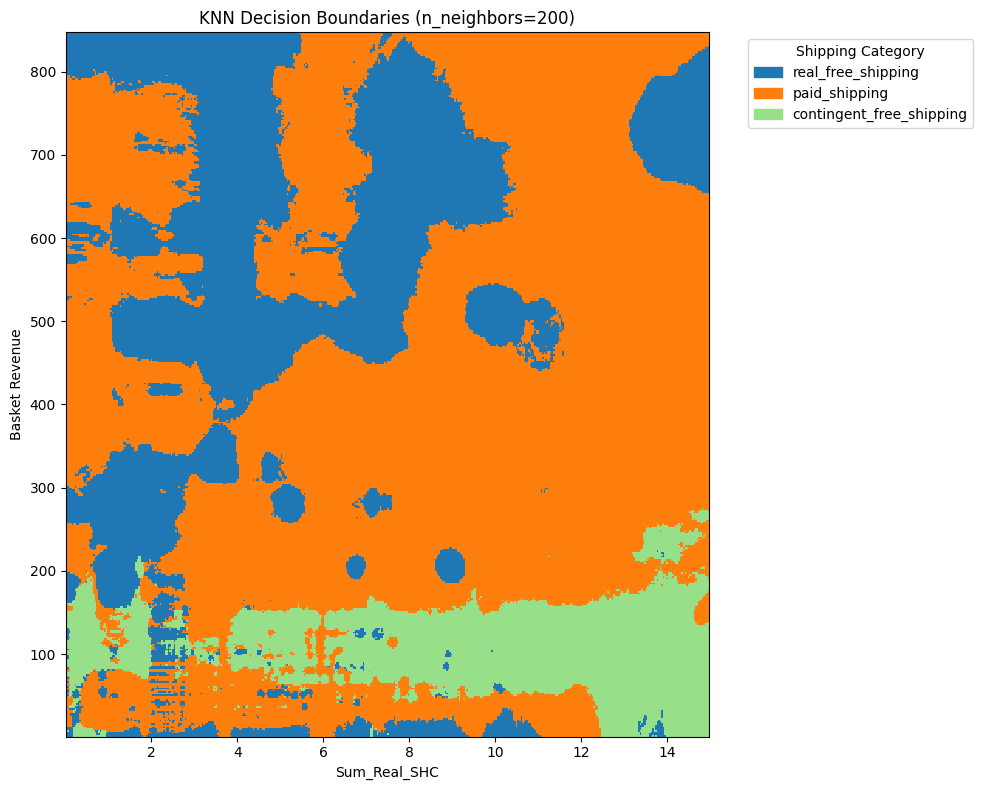

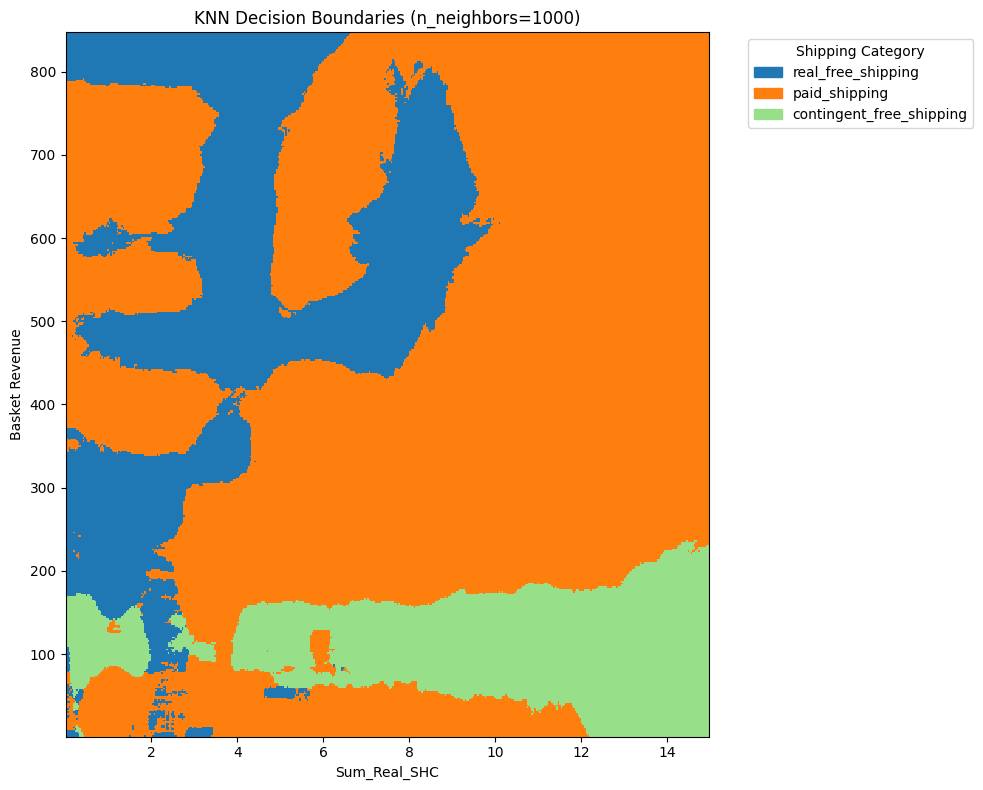

In [175]:
features = df_filtered[['Sum_Real_SHC', 'Basket Revenue']].values
target = df_filtered['Shipping_Category']
# Map string labels to integers
unique_labels = target.unique()
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_to_label = {i: label for label, i in label_to_int.items()}
target_numeric = np.array([label_to_int[label] for label in target])

# Define the boundaries for the meshgrid
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1

# Create the meshgrid
# Determine the number of divisions you want along each axis
num_divisions = 500
h_x = (x_max - x_min) / num_divisions
h_y = (y_max - y_min) / num_divisions

xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))

# Normalize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Update the meshgrid for the scaled features
x_min_scaled, x_max_scaled = 0 - 0.1, 1 + 0.1  # Since MinMaxScaler scales between 0 and 1
y_min_scaled, y_max_scaled = 0 - 0.1, 1 + 0.1
xx_scaled, yy_scaled = np.meshgrid(np.linspace(x_min_scaled, x_max_scaled, num_divisions),
                                   np.linspace(y_min_scaled, y_max_scaled, num_divisions))

def plot_knn_decision_boundaries_scaled(n_neighbors):
    # Fit the KNN classifier on normalized features
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features_scaled, target_numeric)

    # Predict over the scaled meshgrid
    Z = knn.predict(np.c_[xx_scaled.ravel(), yy_scaled.ravel()])
    Z_numeric = Z.reshape(xx_scaled.shape)

    # Inverse transform the scaled coordinates back to the original feature space for plotting
    meshgrid_scaled_points = np.vstack([xx_scaled.ravel(), yy_scaled.ravel()]).T
    meshgrid_original_points = scaler.inverse_transform(meshgrid_scaled_points)
    xx_original, yy_original = meshgrid_original_points[:, 0].reshape(xx_scaled.shape), meshgrid_original_points[:, 1].reshape(yy_scaled.shape)

    # Plot using the original feature space coordinates
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#1f77b4', '#ff7f0e', '#98df8a'])
    plt.pcolormesh(xx_original, yy_original, Z_numeric, cmap=cmap_light, shading='auto')

    # Set plot limits to the exact range of your original, non-normalized features
    plt.xlim(features[:, 0].min(), features[:, 0].max())
    plt.ylim(features[:, 1].min(), features[:, 1].max())
    plt.title(f"KNN Decision Boundaries (n_neighbors={n_neighbors})")
    plt.xlabel('Sum_Real_SHC')
    plt.ylabel('Basket Revenue')

    # Create legend handles manually
    handles = [mpatches.Patch(color=cmap_light.colors[i], label=int_to_label[i]) for i in range(len(unique_labels))]
    plt.legend(handles=handles, title='Shipping Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Call the function with different values of n_neighbors
plot_knn_decision_boundaries_scaled(5)
plot_knn_decision_boundaries_scaled(200)
plot_knn_decision_boundaries_scaled(1000)

# MP Only

['paid_shipping' 'real_free_shipping']


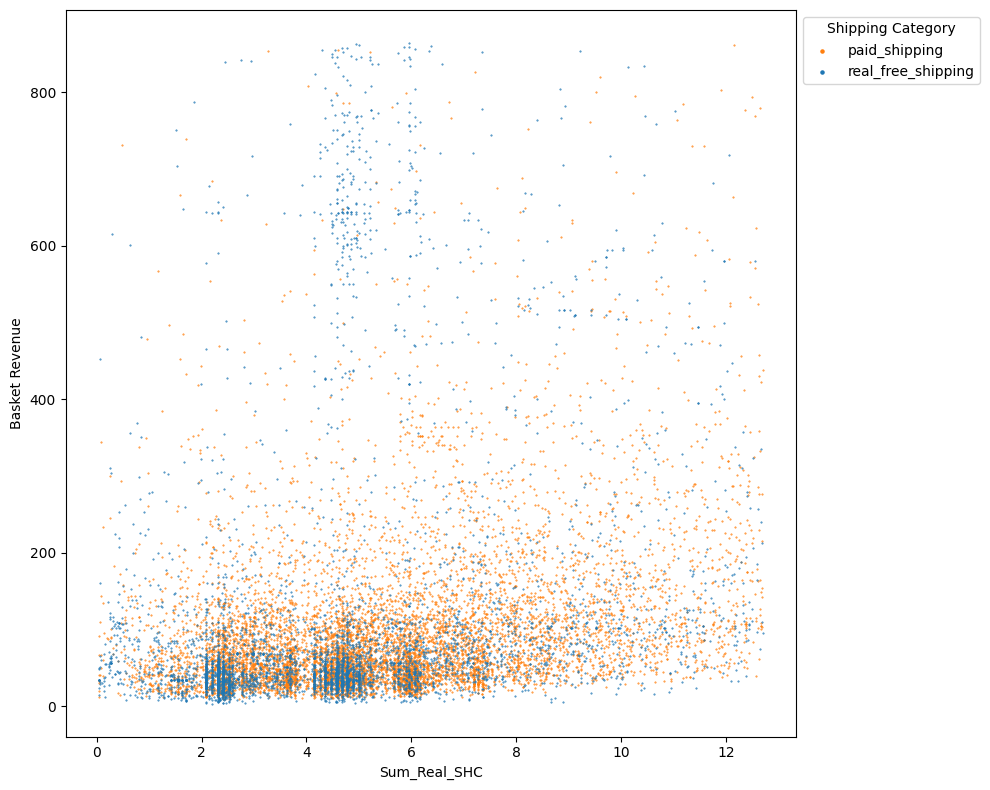

In [237]:
color_map = {
    'paid_shipping': '#ff7f0e',  # Orange
    'real_free_shipping': '#1f77b4',  # Blue
}

quantile_sum_real_shc_mp = transactions_with_multiple_items_mp['Sum_Real_SHC'].quantile(0.9)
quantile_basket_revenue_mp = transactions_with_multiple_items_mp['Basket Revenue'].quantile(0.9)

# Filter out outliers
df_filtered_mp = transactions_with_multiple_items_mp[(transactions_with_multiple_items_mp['Sum_Real_SHC'] <= quantile_sum_real_shc_mp) &
                      (transactions_with_multiple_items_mp['Basket Revenue'] <= quantile_basket_revenue_mp)]

# Exclude 'mixed_shipping' from the filtered DataFrame
df_filtered_mp = df_filtered_mp[df_filtered_mp['Shipping_Category'] != 'mixed_shipping']

# Plotting with an enlarged figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

# Now 'categories' will only include categories present in 'df_filtered', excluding 'mixed_shipping'
categories = df_filtered_mp['Shipping_Category'].unique()
print(categories)
for category in categories:
    subset = df_filtered_mp[df_filtered_mp['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, color=color_map.get(category, '#808080'), s=0.2)  # Dot size in the plot

ax.set_xlabel('Sum_Real_SHC')
ax.set_ylabel('Basket Revenue')
# Placing the legend outside the plot on the right, enlarging the dots only in the legend
ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)  # Increase markerscale as needed
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

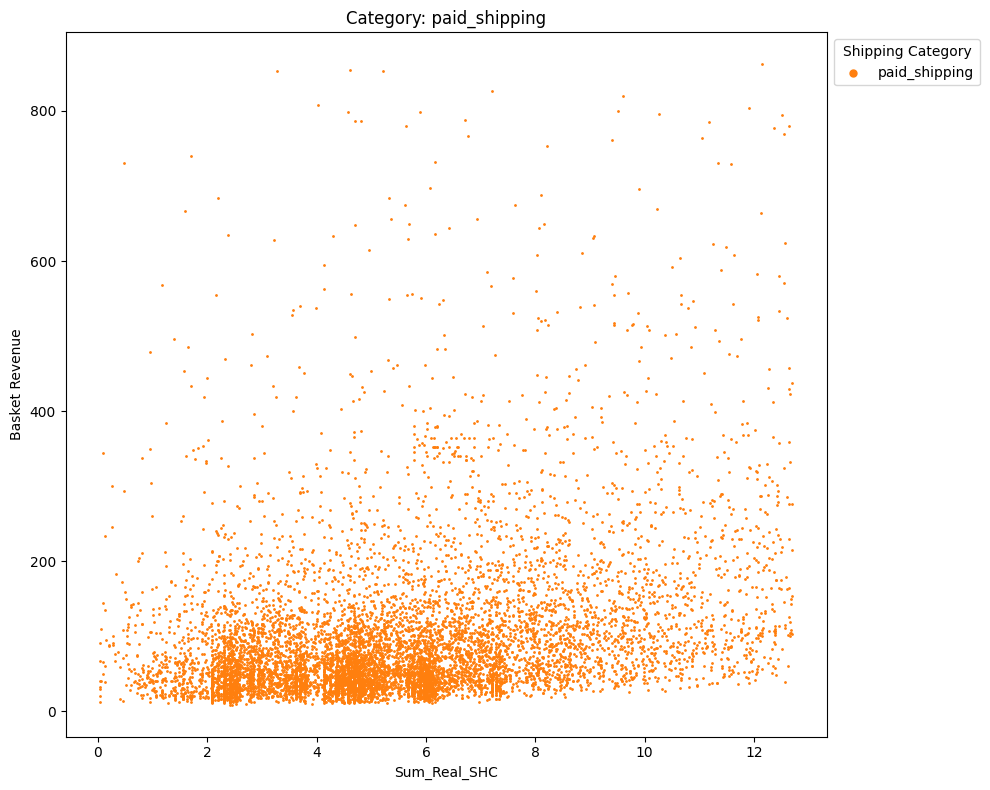

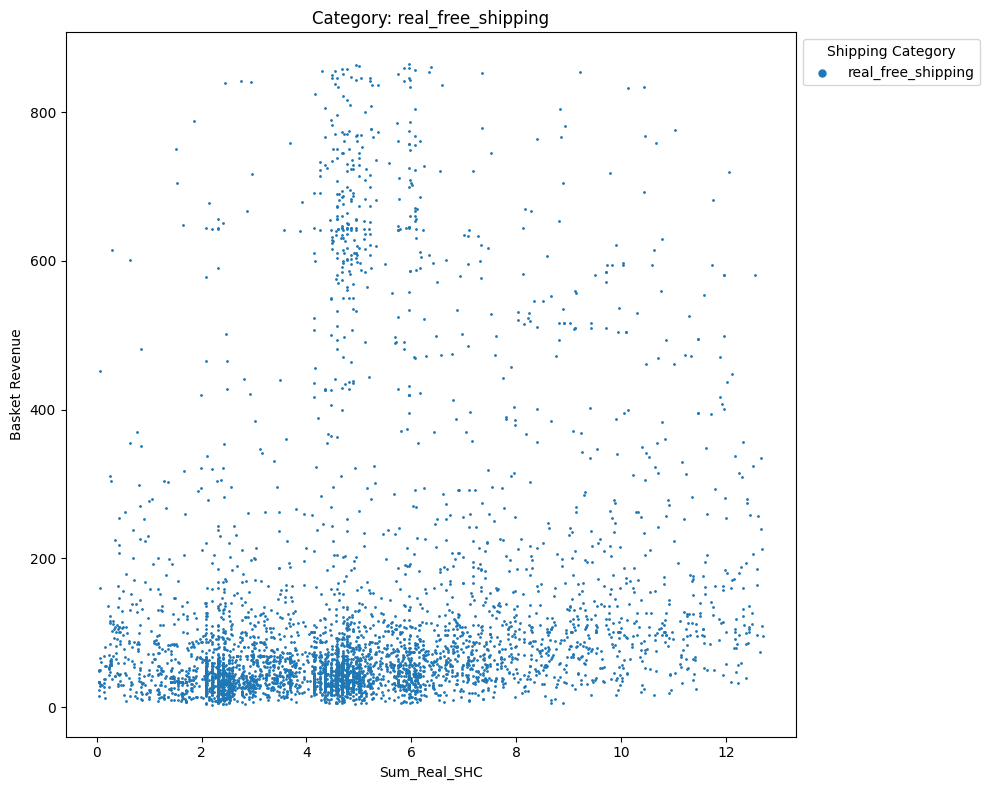

In [238]:
# Create a color map for consistent coloring across plots
categories_mp = df_filtered_mp['Shipping_Category'].unique()

# Plot separate graphs for each category using the color map
for category in categories_mp:
    fig, ax = plt.subplots(figsize=(10, 8))
    subset = df_filtered_mp[df_filtered_mp['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=1, color=color_map[category])
    
    ax.set_xlabel('Sum_Real_SHC')
    ax.set_ylabel('Basket Revenue')
    ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)
    plt.title(f"Category: {category}")
    plt.tight_layout()
    plt.show()

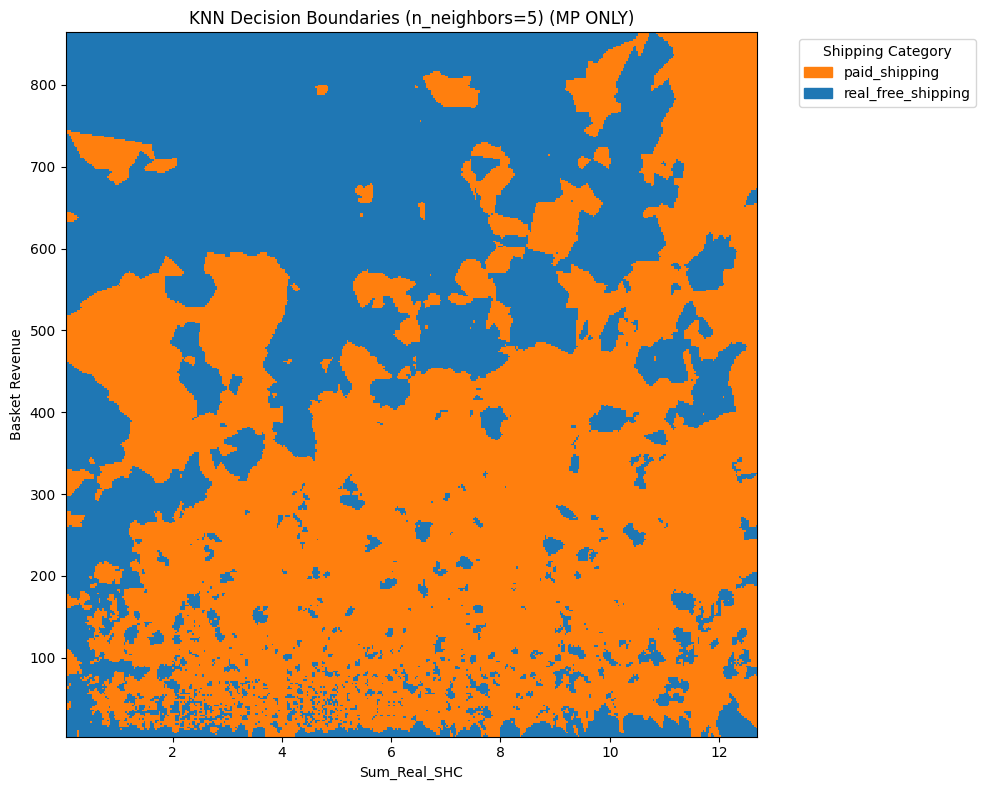

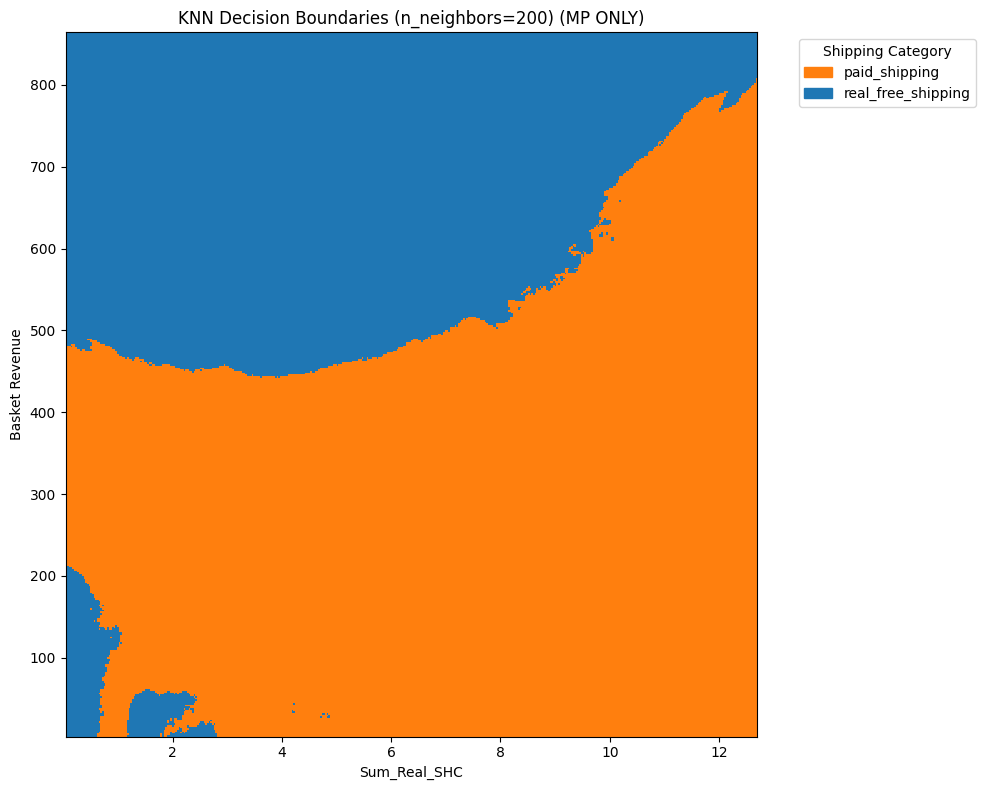

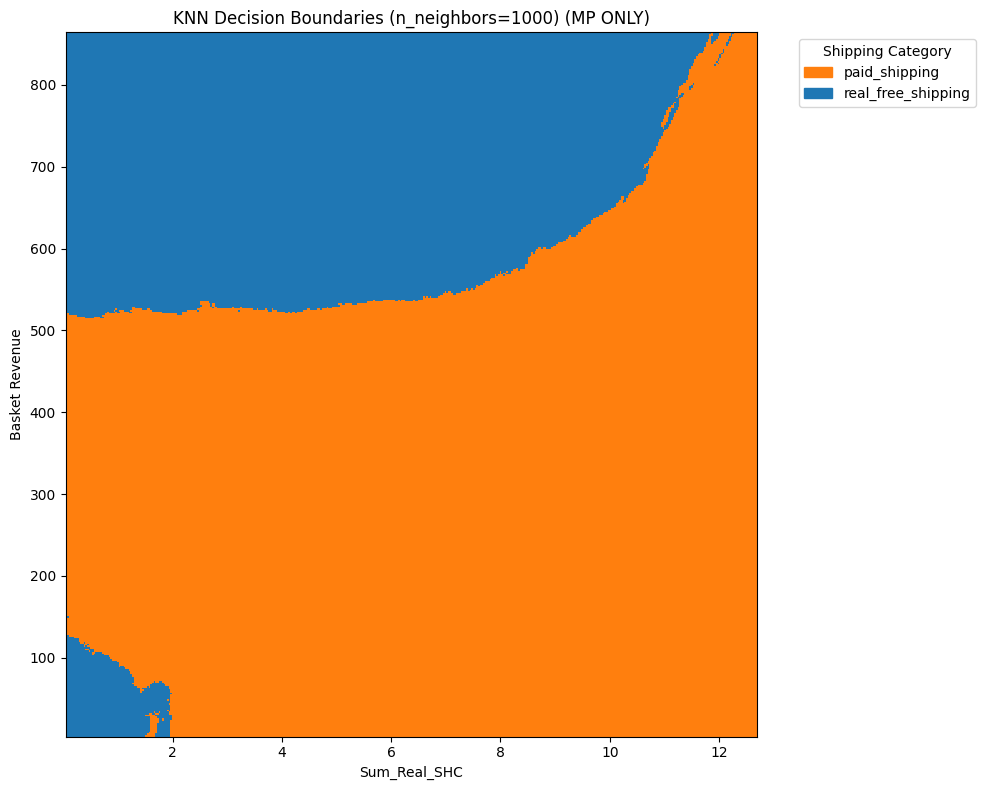

In [240]:
features_mp = df_filtered_mp[['Sum_Real_SHC', 'Basket Revenue']].values
target_mp = df_filtered_mp['Shipping_Category']
# Map string labels to integers
unique_labels_mp = target_mp.unique()
label_to_int_mp = {label: i for i, label in enumerate(unique_labels_mp)}
int_to_label_mp = {i: label for label, i in label_to_int_mp.items()}
target_numeric_mp = np.array([label_to_int_mp[label] for label in target_mp])

# Define the boundaries for the meshgrid
x_min_mp, x_max_mp = features_mp[:, 0].min() - 1, features_mp[:, 0].max() + 1
y_min_mp, y_max_mp = features_mp[:, 1].min() - 1, features_mp[:, 1].max() + 1

# Create the meshgrid
# Determine the number of divisions you want along each axis
num_divisions_mp = 500
h_x_mp = (x_max_mp - x_min_mp) / num_divisions_mp
h_y_mp = (y_max_mp - y_min_mp) / num_divisions_mp

xx_mp, yy_mp = np.meshgrid(np.arange(x_min_mp, x_max_mp, h_x_mp), np.arange(y_min_mp, y_max_mp, h_y_mp))

# Normalize the features
scaler = MinMaxScaler()
features_scaled_mp = scaler.fit_transform(features_mp)

# Update the meshgrid for the scaled features
x_min_scaled_mp, x_max_scaled_mp = 0 - 0.1, 1 + 0.1  # Since MinMaxScaler scales between 0 and 1
y_min_scaled_mp, y_max_scaled_mp = 0 - 0.1, 1 + 0.1
xx_scaled_mp, yy_scaled_mp = np.meshgrid(np.linspace(x_min_scaled_mp, x_max_scaled_mp, num_divisions_mp),
                                   np.linspace(y_min_scaled_mp, y_max_scaled_mp, num_divisions_mp))

def plot_knn_decision_boundaries_scaled_mp(n_neighbors):
    # Fit the KNN classifier on normalized features
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features_scaled_mp, target_numeric_mp)

    # Predict over the scaled meshgrid
    Z_mp = knn.predict(np.c_[xx_scaled_mp.ravel(), yy_scaled_mp.ravel()])
    Z_numeric_mp = Z_mp.reshape(xx_scaled_mp.shape)

    # Inverse transform the scaled coordinates back to the original feature space for plotting
    meshgrid_scaled_points_mp = np.vstack([xx_scaled_mp.ravel(), yy_scaled_mp.ravel()]).T
    meshgrid_original_points_mp = scaler.inverse_transform(meshgrid_scaled_points_mp)
    xx_original_mp, yy_original_mp = meshgrid_original_points_mp[:, 0].reshape(xx_scaled_mp.shape), meshgrid_original_points_mp[:, 1].reshape(yy_scaled_mp.shape)

    # Plot using the original feature space coordinates
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#ff7f0e', '#1f77b4'])
    plt.pcolormesh(xx_original_mp, yy_original_mp, Z_numeric_mp, cmap=cmap_light, shading='auto')

    # Set plot limits to the exact range of your original, non-normalized features
    plt.xlim(features_mp[:, 0].min(), features_mp[:, 0].max())
    plt.ylim(features_mp[:, 1].min(), features_mp[:, 1].max())
    plt.title(f"KNN Decision Boundaries (n_neighbors={n_neighbors}) (MP ONLY)")
    plt.xlabel('Sum_Real_SHC')
    plt.ylabel('Basket Revenue')

    # Create legend handles manually
    handles = [mpatches.Patch(color=cmap_light.colors[i], label=int_to_label_mp[i]) for i in range(len(unique_labels_mp))]
    plt.legend(handles=handles, title='Shipping Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Call the function with different values of n_neighbors
plot_knn_decision_boundaries_scaled_mp(5)
plot_knn_decision_boundaries_scaled_mp(200)
plot_knn_decision_boundaries_scaled_mp(1000)

# PO

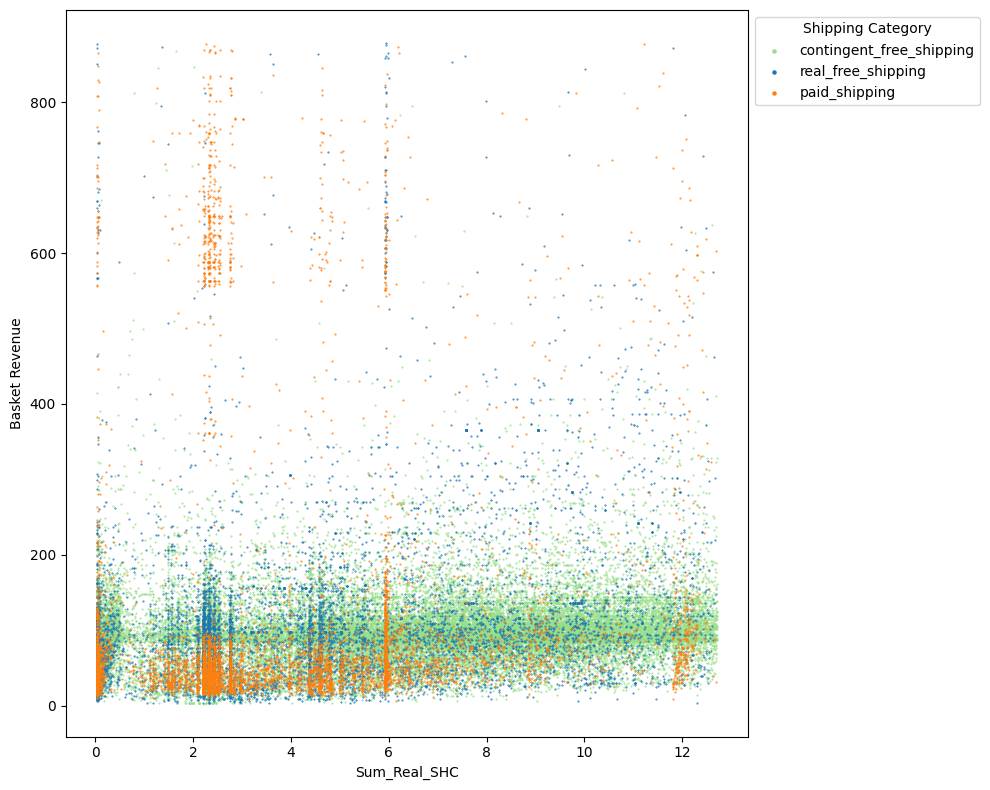

In [225]:
color_map = {
    'paid_shipping': '#ff7f0e',  # Orange
    'real_free_shipping': '#1f77b4',  # Blue
    'contingent_free_shipping': '#98df8a'  # Green
}
quantile_sum_real_shc_po = transactions_with_multiple_items_po['Sum_Real_SHC'].quantile(0.85)
quantile_basket_revenue_po = transactions_with_multiple_items_po['Basket Revenue'].quantile(0.924)

# Filter out outliers
df_filtered_po = transactions_with_multiple_items_po[(transactions_with_multiple_items_po['Sum_Real_SHC'] <= quantile_sum_real_shc_po) &
                      (transactions_with_multiple_items_po['Basket Revenue'] <= quantile_basket_revenue_po)]

# Exclude 'mixed_shipping' from the filtered DataFrame
df_filtered_po = df_filtered_po[df_filtered_po['Shipping_Category'] != 'mixed_shipping']

# Plotting with an enlarged figure size
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed

# Now 'categories' will only include categories present in 'df_filtered', excluding 'mixed_shipping'
categories = df_filtered_po['Shipping_Category'].unique()

for category in categories:
    subset = df_filtered_po[df_filtered_po['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, color=color_map[category], s=0.2)  # Dot size in the plot

ax.set_xlabel('Sum_Real_SHC')
ax.set_ylabel('Basket Revenue')
# Placing the legend outside the plot on the right, enlarging the dots only in the legend
ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)  # Increase markerscale as needed
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

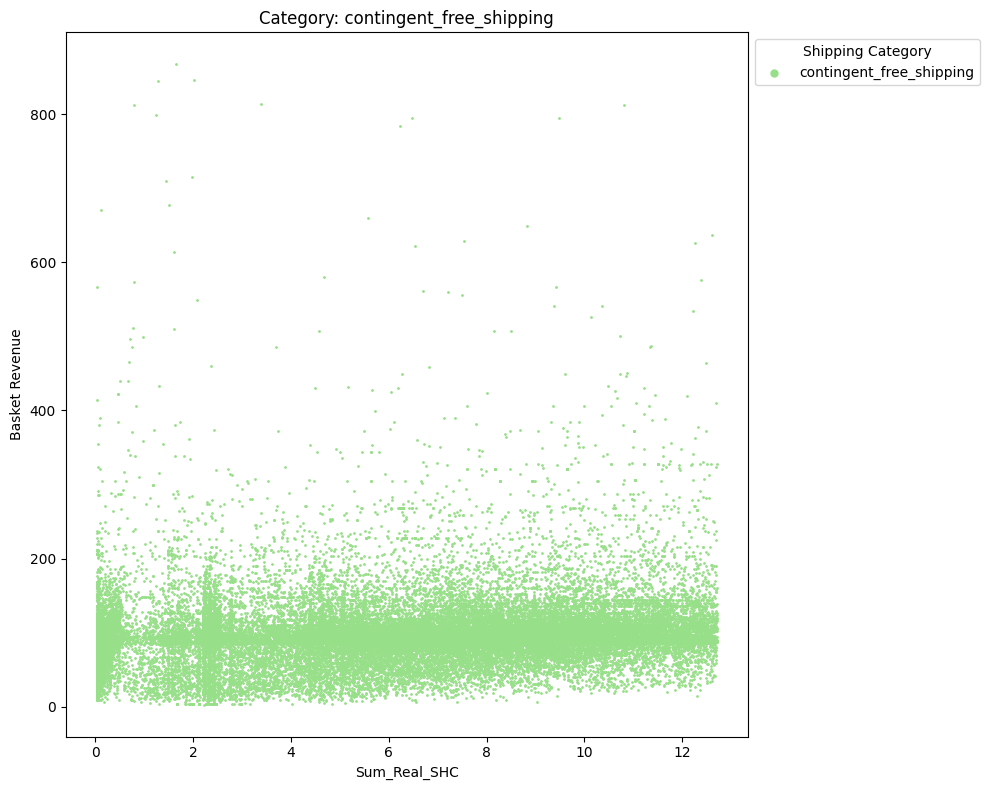

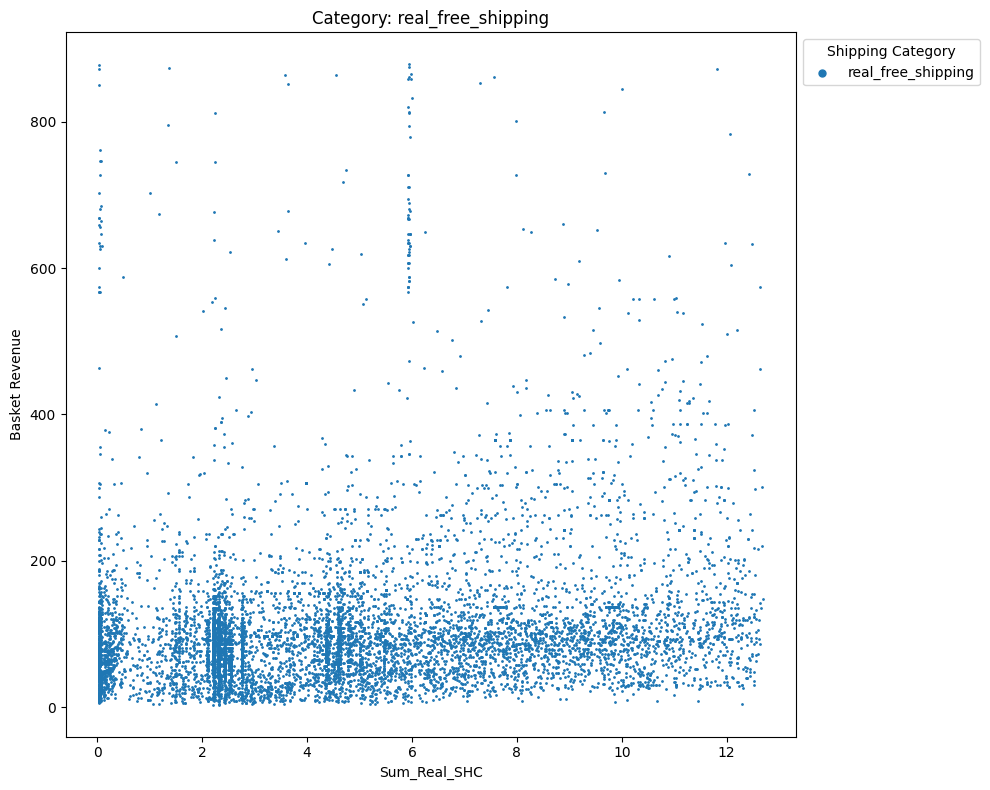

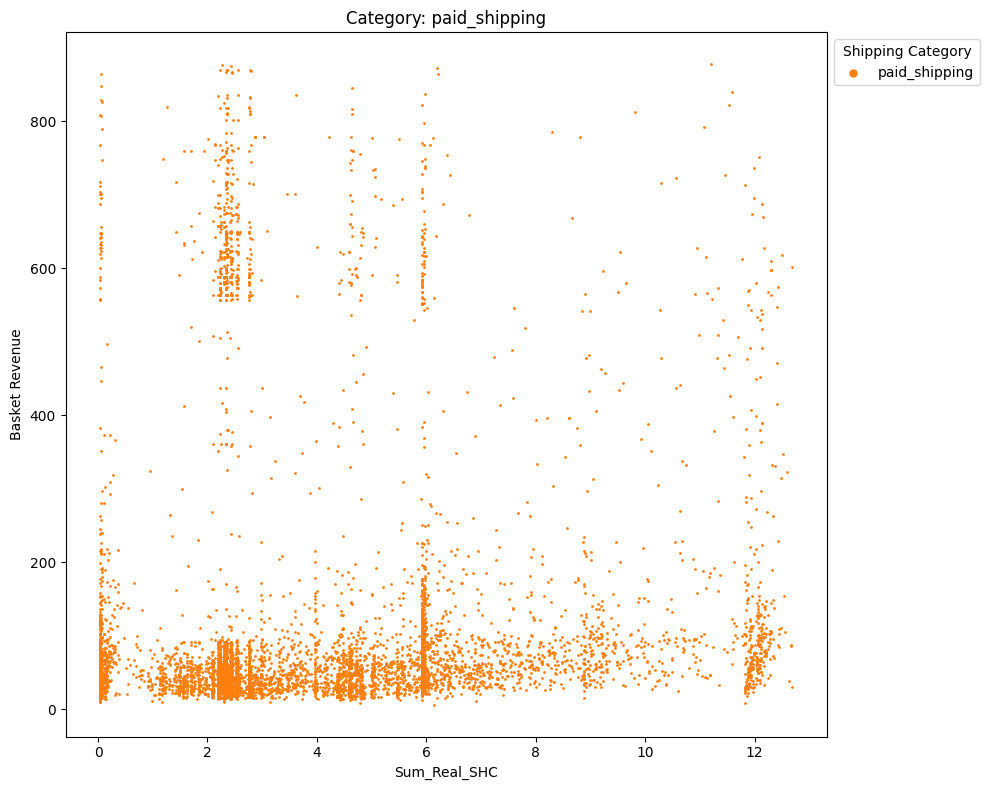

In [226]:
# Create a color map for consistent coloring across plots
categories_po = df_filtered_po['Shipping_Category'].unique()

# Plot separate graphs for each category using the color map
for category in categories_po:
    fig, ax = plt.subplots(figsize=(10, 8))
    subset = df_filtered_po[df_filtered_po['Shipping_Category'] == category]
    ax.scatter(subset['Sum_Real_SHC'], subset['Basket Revenue'], label=category, s=1, color=color_map[category])
    
    ax.set_xlabel('Sum_Real_SHC')
    ax.set_ylabel('Basket Revenue')
    ax.legend(title='Shipping Category', loc='upper left', bbox_to_anchor=(1, 1), markerscale=5)
    plt.title(f"Category: {category}")
    plt.tight_layout()
    plt.show()

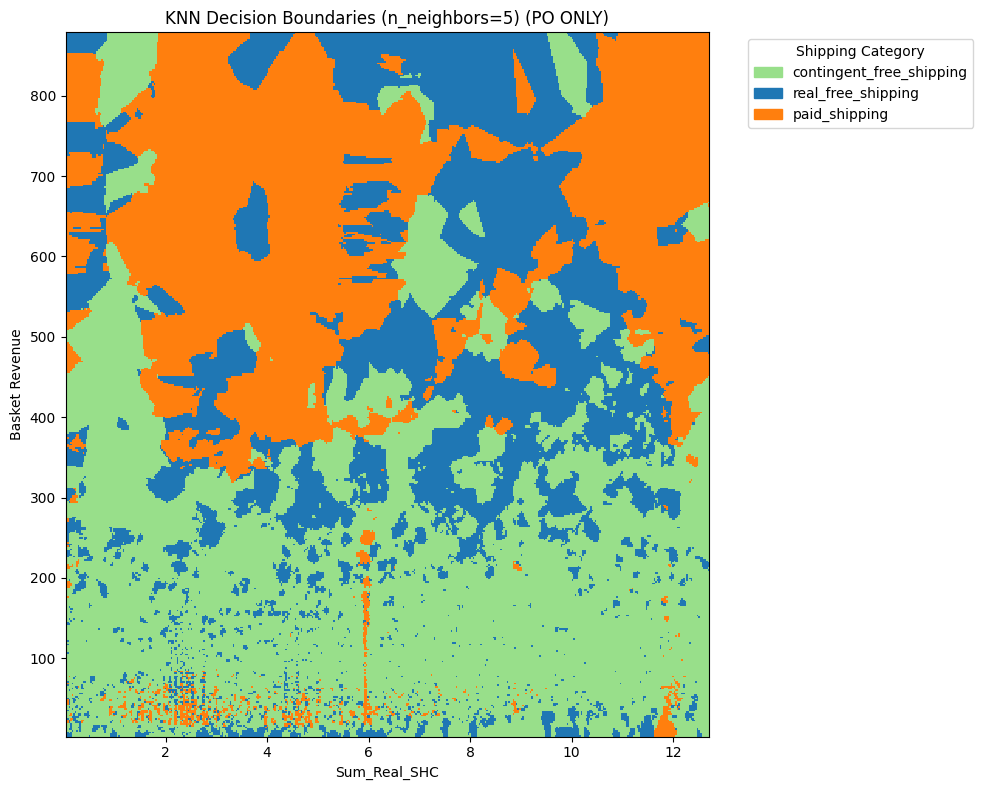

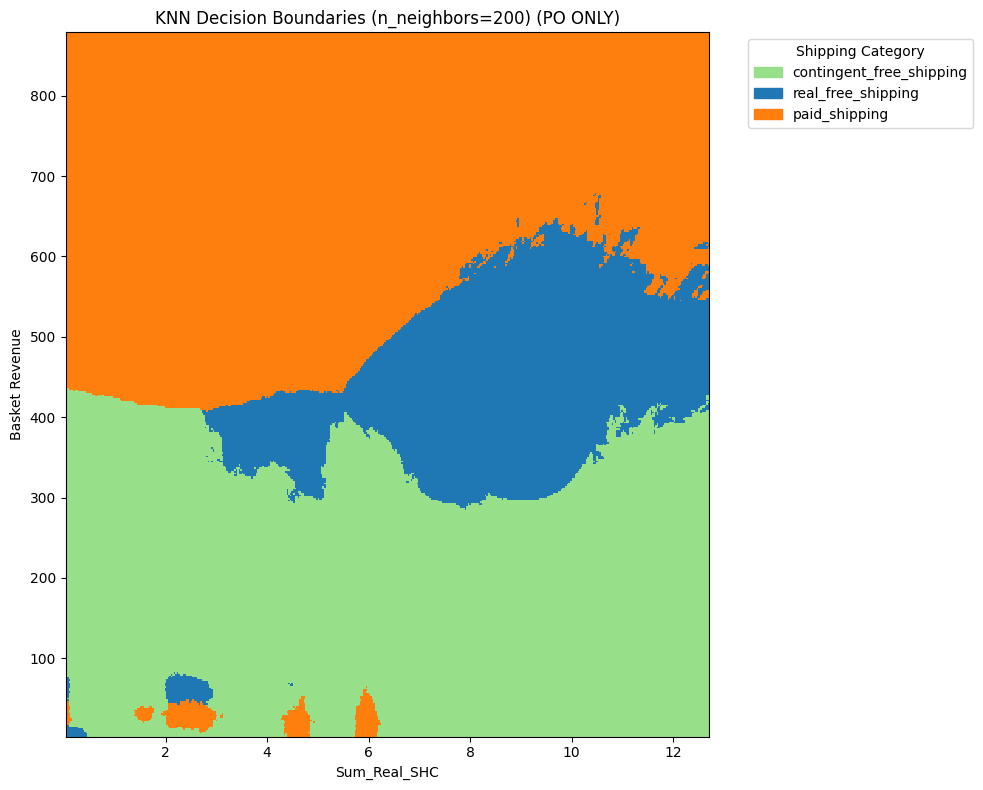

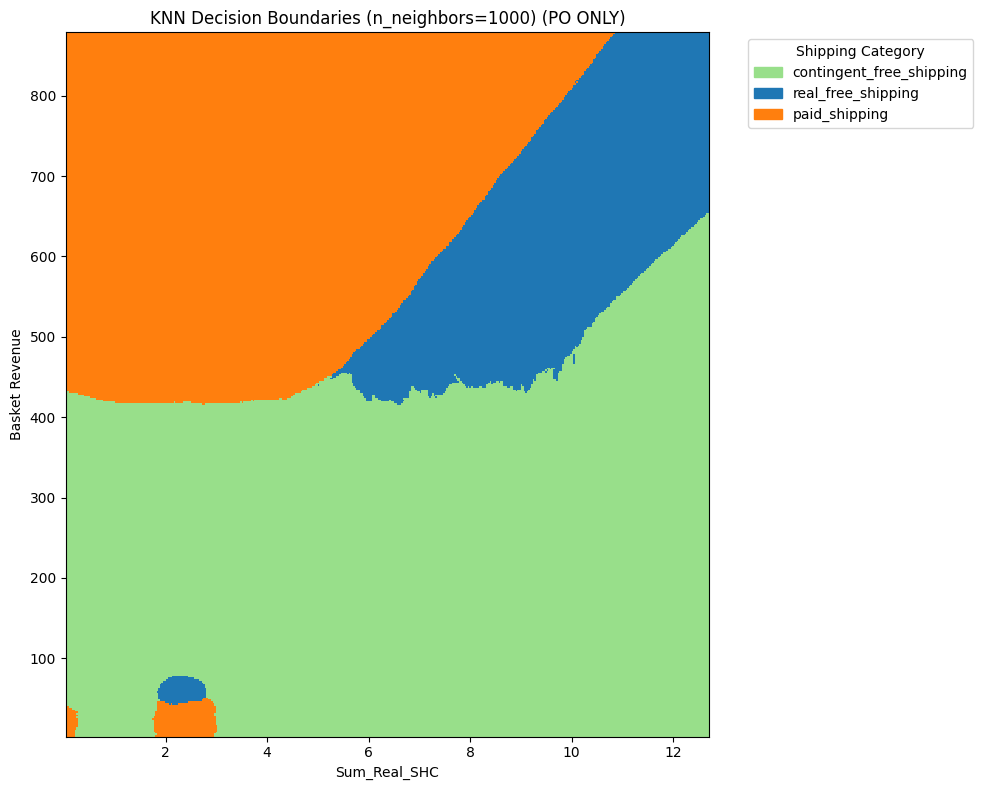

In [230]:
features_po = df_filtered_po[['Sum_Real_SHC', 'Basket Revenue']].values
target_po = df_filtered_po['Shipping_Category']
# Map string labels to integers
unique_labels_po = target_po.unique()
label_to_int_po = {label: i for i, label in enumerate(unique_labels_po)}
int_to_label_po = {i: label for label, i in label_to_int_po.items()}
target_numeric_po = np.array([label_to_int_po[label] for label in target_po])

# Define the boundaries for the meshgrid
x_min_po, x_max_po = features_po[:, 0].min() - 1, features_po[:, 0].max() + 1
y_min_po, y_max_po = features_po[:, 1].min() - 1, features_po[:, 1].max() + 1

# Create the meshgrid
# Determine the number of divisions you want along each axis
num_divisions_po = 500
h_x_po = (x_max_po - x_min_po) / num_divisions_po
h_y_po = (y_max_po - y_min_po) / num_divisions_po

xx_po, yy_po = np.meshgrid(np.arange(x_min_po, x_max_po, h_x_po), np.arange(y_min_po, y_max_po, h_y_po))

# Normalize the features
scaler = MinMaxScaler()
features_scaled_po = scaler.fit_transform(features_po)

# Update the meshgrid for the scaled features
x_min_scaled_po, x_max_scaled_po = 0 - 0.1, 1 + 0.1  # Since MinMaxScaler scales between 0 and 1
y_min_scaled_po, y_max_scaled_po = 0 - 0.1, 1 + 0.1
xx_scaled_po, yy_scaled_po = np.meshgrid(np.linspace(x_min_scaled_po, x_max_scaled_po, num_divisions_po),
                                   np.linspace(y_min_scaled_po, y_max_scaled_po, num_divisions_po))

def plot_knn_decision_boundaries_scaled_po(n_neighbors):
    # Fit the KNN classifier on normalized features
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(features_scaled_po, target_numeric_po)

    # Predict over the scaled meshgrid
    Z_po = knn.predict(np.c_[xx_scaled_po.ravel(), yy_scaled_po.ravel()])
    Z_numeric_po = Z_po.reshape(xx_scaled_po.shape)

    # Inverse transform the scaled coordinates back to the original feature space for plotting
    meshgrid_scaled_points_po = np.vstack([xx_scaled_po.ravel(), yy_scaled_po.ravel()]).T
    meshgrid_original_points_po = scaler.inverse_transform(meshgrid_scaled_points_po)
    xx_original_po, yy_original_po = meshgrid_original_points_po[:, 0].reshape(xx_scaled_po.shape), meshgrid_original_points_po[:, 1].reshape(yy_scaled_po.shape)

    # Plot using the original feature space coordinates
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#98df8a', '#1f77b4', '#ff7f0e'])
    plt.pcolormesh(xx_original_po, yy_original_po, Z_numeric_po, cmap=cmap_light, shading='auto')

    # Set plot limits to the exact range of your original, non-normalized features
    plt.xlim(features_po[:, 0].min(), features_po[:, 0].max())
    plt.ylim(features_po[:, 1].min(), features_po[:, 1].max())
    plt.title(f"KNN Decision Boundaries (n_neighbors={n_neighbors}) (PO ONLY)")
    plt.xlabel('Sum_Real_SHC')
    plt.ylabel('Basket Revenue')

    # Create legend handles manually
    handles = [mpatches.Patch(color=cmap_light.colors[i], label=int_to_label_po[i]) for i in range(len(unique_labels_po))]
    plt.legend(handles=handles, title='Shipping Category', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


# Call the function with different values of n_neighbors
plot_knn_decision_boundaries_scaled_po(5)
plot_knn_decision_boundaries_scaled_po(200)
plot_knn_decision_boundaries_scaled_po(1000)

# ---------------------------------------------------------------------------------------------------------------

# Time Series Analysis (Category-Based) of Daily Revenues to see "Weekend" effect

In [38]:
daily_revenue_by_category_weekend = df.groupby(['DATE', 'Category', 'Weekend'])['Revenue'].sum().reset_index()
daily_revenue_by_category_weekend

DATE Category  Weekend     Revenue
0   2017-03-01       BC    False   115624.87
1   2017-03-01      HEA    False   533457.91
2   2017-03-01      PET    False    76866.07
3   2017-03-01     TEL1    False   130159.51
4   2017-03-01     TEL2    False  1950022.14
..         ...      ...      ...         ...
300 2017-04-30       BC     True   165042.40
301 2017-04-30      HEA     True   315769.92
302 2017-04-30      PET     True    42001.08
303 2017-04-30     TEL1     True    86657.71
304 2017-04-30     TEL2     True   875034.44

[305 rows x 4 columns]

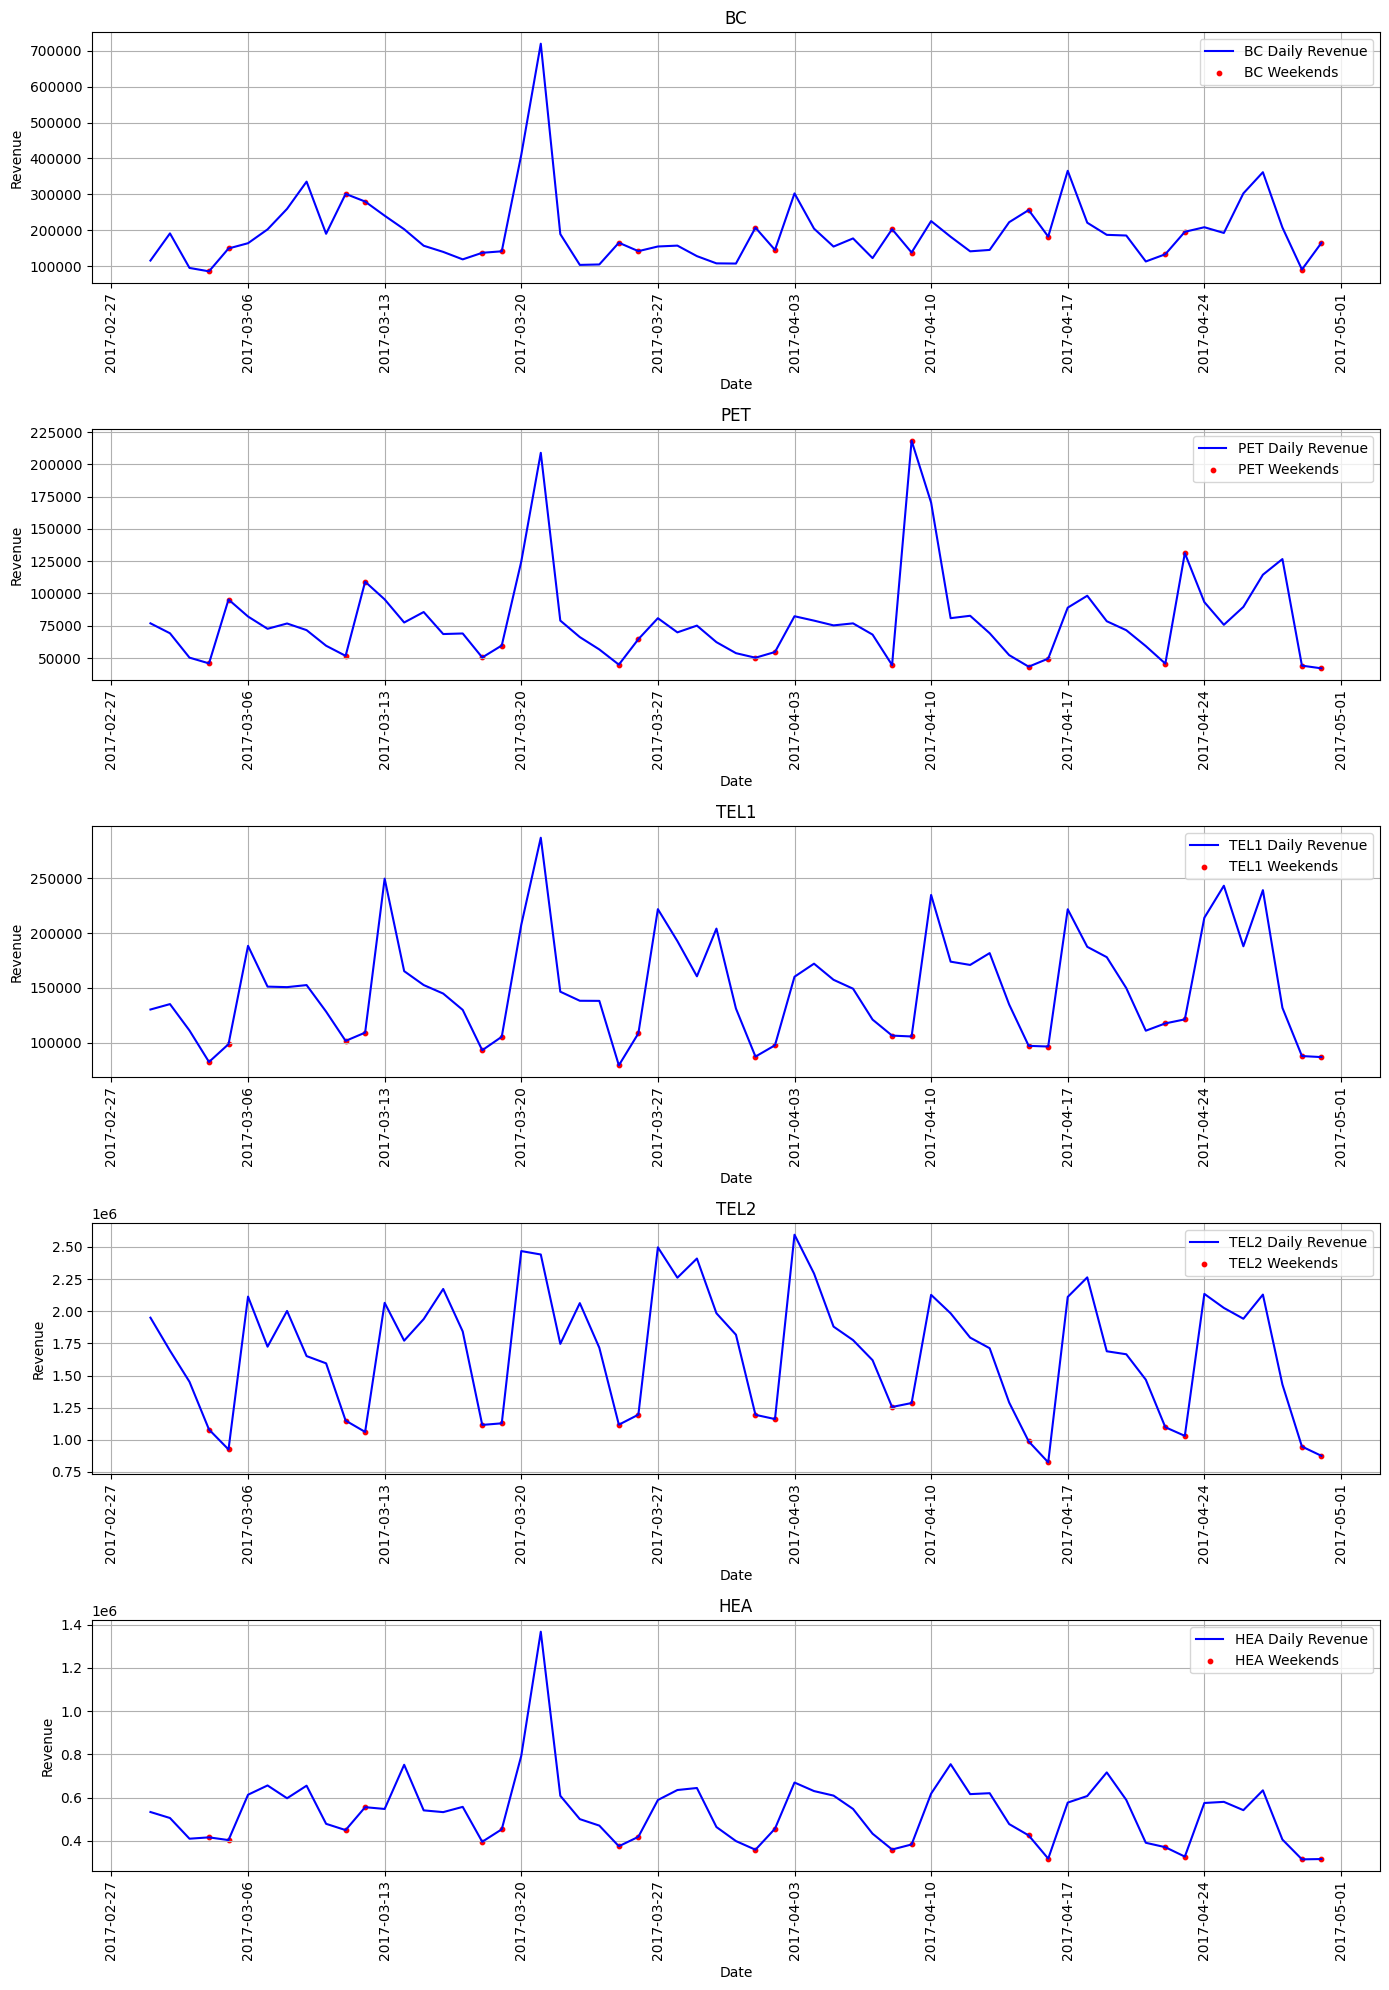

In [39]:
plt.figure(figsize=(14, 20))

categories = df["Category"].unique()
for i, category in enumerate(categories, start=1):
    plt.subplot(len(categories), 1, i)
    category_data = daily_revenue_by_category_weekend[daily_revenue_by_category_weekend['Category'] == category]
    
    # Plot all data as a line
    plt.plot(category_data['DATE'], category_data['Revenue'], label=f"{category} Daily Revenue", color='blue')
    
    # Mark weekend data points based on 'Weekend' column
    weekend_data = category_data[category_data['Weekend'] == True]
    plt.scatter(weekend_data['DATE'], weekend_data['Revenue'], label=f"{category} Weekends", color='red', s=10)  # s is the size of the marker
    
    plt.title(category)
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    weekly_locator = WeekdayLocator(byweekday=MO)
    formatter = DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_locator(weekly_locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.show()

# Time Series Analysis (Campaign-Based) of Daily Revenues

In [40]:
# Grouping by 'DATE', 'CAMPAIGN', and 'Weekend' to sum the revenues
grouped_revenue = df.groupby(['DATE', 'CAMPAIGN', 'Weekend'])['Revenue'].sum().reset_index()

# Calculating total daily revenue
daily_total_revenue = grouped_revenue.groupby('DATE')['Revenue'].sum().reset_index()
daily_total_revenue = daily_total_revenue.rename(columns={'Revenue': 'Total_Daily_Revenue'})

# Merging to get total daily revenue back into our grouped dataframe
grouped_revenue_with_total = pd.merge(grouped_revenue, daily_total_revenue, on='DATE')

# Calculating the percentage
grouped_revenue_with_total['Percentage'] = (grouped_revenue_with_total['Revenue'] / grouped_revenue_with_total['Total_Daily_Revenue']) * 100

grouped_revenue_with_total

DATE                      CAMPAIGN  Weekend     Revenue  \
0   2017-03-01             100 TL üzeri çatı    False   120148.78   
1   2017-03-01    Kampanya Modülü Kampanyası    False   632065.59   
2   2017-03-01  Kargo Bedava Ürün Kampanyası    False    27054.57   
3   2017-03-01                         Other    False   989356.83   
4   2017-03-01     Ürüne Sabit Ücretli Kargo    False  1037504.73   
..         ...                           ...      ...         ...   
331 2017-04-30       Desi Bazlı Kargo Ücreti     True   149710.33   
332 2017-04-30    Kampanya Modülü Kampanyası     True   531525.09   
333 2017-04-30  Kargo Bedava Ürün Kampanyası     True    29975.10   
334 2017-04-30                         Other     True   429219.02   
335 2017-04-30     Ürüne Sabit Ücretli Kargo     True   250032.12   

     Total_Daily_Revenue  Percentage  
0             2806130.50    4.281653  
1             2806130.50   22.524455  
2             2806130.50    0.964124  
3             2806130.50   35.256979  
4             2806130.50   36.972790  
..                   ...         ...  
331           1484505.55   10.084862  
332           1484505.55   35.804857  
333           1484505.55    2.019198  
334           1484505.55   28.913265  
335           1484505.55   16.842788  

[336 rows x 6 columns]

In [41]:
campaigns = df['CAMPAIGN'].unique()
campaigns

array(['100 TL üzeri çatı', 'Kampanya Modülü Kampanyası', 'Other',
       'Kargo Bedava Ürün Kampanyası', 'Ürüne Sabit Ücretli Kargo',
       'Desi Bazlı Kargo Ücreti', 'Maliyetsiz Kargo Bedava'], dtype=object)

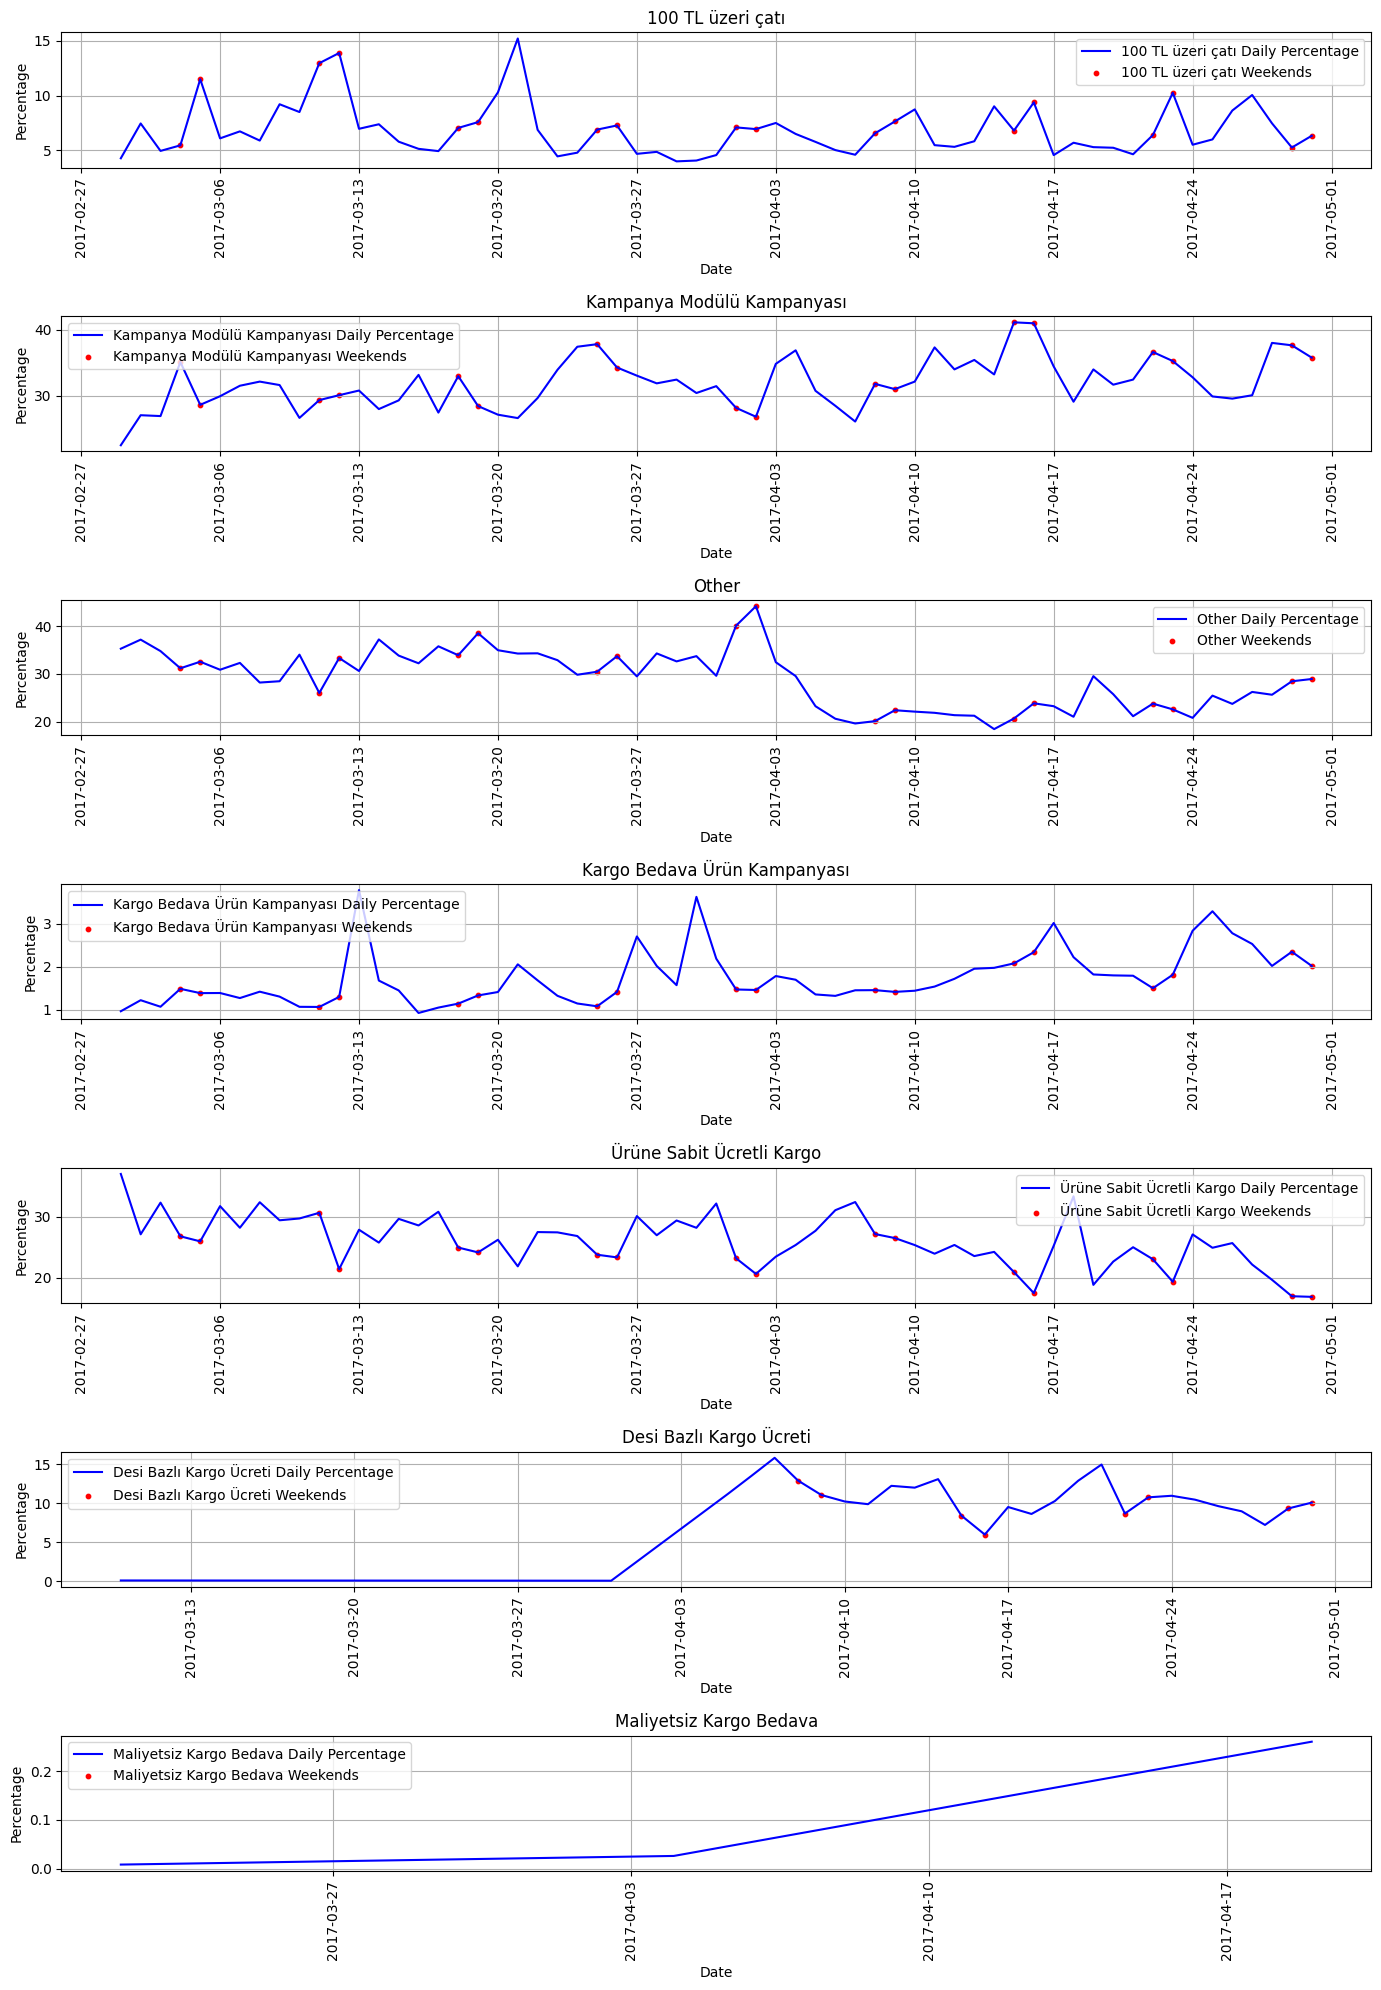

In [42]:
plt.figure(figsize=(14, 20))

for i, campaign in enumerate(campaigns, start=1):
    plt.subplot(len(campaigns), 1, i)
    campaign_data = grouped_revenue_with_total[grouped_revenue_with_total['CAMPAIGN'] == campaign]
    
    # Plot all data as a line
    plt.plot(campaign_data['DATE'], campaign_data['Percentage'], label=f"{campaign} Daily Percentage", color='blue')
    
    # Mark weekend data points based on 'Weekend' column
    weekend_data = campaign_data[campaign_data['Weekend'] == True]
    plt.scatter(weekend_data['DATE'], weekend_data['Percentage'], label=f"{campaign} Weekends", color='red', s=10)  # s is the size of the marker
    
    plt.title(campaign)
    plt.xlabel('Date')
    plt.ylabel('Percentage')
    weekly_locator = WeekdayLocator(byweekday=MO)
    formatter = DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_locator(weekly_locator)
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid()
    plt.tight_layout()

plt.show()

# Market Basket Analysis with Apriori Algorithm (According to Sub Category)

## All Shipping Categories

In [130]:
# Prepare the list of sub-category lists for the apriori algorithm
transactions = transactions_with_multiple_items['SUB_CATEGORY'].tolist()

encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets = apriori(transactions_df, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted.head())

     support                            itemsets
14  0.279528  (Deterjan ve Temizlik Malzemeleri)
50  0.228463                  (Telefon Kılıflar)
8   0.211963                        (Bebek Bezi)
11  0.102696                      (Cep Telefonu)
20  0.077924                    (Kağıt Ürünleri)


In [131]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted = rules.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted.head())

                    antecedents                         consequents  \
14       (Ek Güvence Paketleri)                      (Cep Telefonu)   
62         (Kuş Bakım Ürünleri)                       (Kuş Yemleri)   
16               (Cep Telefonu)                  (Telefon Kılıflar)   
72         (Tv Askı Aparatları)                    (LCD Televizyon)   
90  (Kağıt Ürünleri, İçecekler)  (Deterjan ve Temizlik Malzemeleri)   

    antecedent support  consequent support   support  confidence       lift  \
14            0.004572            0.102696  0.004564    0.998285   9.720775   
62            0.006477            0.016907  0.004940    0.762712  45.112496   
16            0.102696            0.228463  0.077234    0.752062   3.291838   
72            0.013308            0.016319  0.009936    0.746612  45.751760   
90            0.005756            0.279528  0.003952    0.686649   2.456455   

    leverage  conviction  zhangs_metric  
14  0.004094  523.128229       0.901248  
62  0.004831  

## Real Free Shipping

In [132]:
# Prepare the list of sub-category lists for the apriori algorithm
rfs_transactions = transactions_with_multiple_items[transactions_with_multiple_items['Shipping_Category'] == 'real_free_shipping']
cfs_transactions = transactions_with_multiple_items[transactions_with_multiple_items['Shipping_Category'] == 'contingent_free_shipping']
ps_transactions = transactions_with_multiple_items[transactions_with_multiple_items['Shipping_Category'] == 'paid_shipping']

transactions_rfs_list = rfs_transactions['SUB_CATEGORY'].tolist()
transactions_cfs_list = cfs_transactions['SUB_CATEGORY'].tolist()
transactions_ps_list = ps_transactions['SUB_CATEGORY'].tolist()


encoder = TransactionEncoder()
transactions_encoded_rfs = encoder.fit_transform(transactions_rfs_list)
transactions_df_rfs = pd.DataFrame(transactions_encoded_rfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_rfs = apriori(transactions_df_rfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_rfs = frequent_itemsets_rfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_rfs.head())

     support                            itemsets
39  0.282454                  (Telefon Kılıflar)
11  0.253897  (Deterjan ve Temizlik Malzemeleri)
6   0.171426                        (Bebek Bezi)
8   0.103005                      (Cep Telefonu)
19  0.072661                       (Kedi Maması)


In [133]:
# Generate association rules
rules_rfs = association_rules(frequent_itemsets_rfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_rfs = rules_rfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_rfs.head())

               antecedents         consequents  antecedent support  \
8   (Ek Güvence Paketleri)      (Cep Telefonu)            0.003367   
53    (Tv Askı Aparatları)    (LCD Televizyon)            0.009145   
43    (Kuş Bakım Ürünleri)       (Kuş Yemleri)            0.005154   
10          (Cep Telefonu)  (Telefon Kılıflar)            0.103005   
41      (Kuş Aksesuarları)       (Kuş Yemleri)            0.005986   

    consequent support   support  confidence       lift  leverage  conviction  \
8             0.103005  0.003367    1.000000   9.708232  0.003020         inf   
53            0.016004  0.008438    0.922727  57.657273  0.008292   12.734070   
43            0.012387  0.004115    0.798387  64.452344  0.004051    4.898559   
10            0.282454  0.069668    0.676352   2.394554  0.040574    2.217056   
41            0.012387  0.003866    0.645833  52.136955  0.003792    2.788554   

    zhangs_metric  
8        0.900025  
53       0.991725  
43       0.989585  
10       0.6

## Contingent Free Shipping

In [134]:
transactions_encoded_cfs = encoder.fit_transform(transactions_cfs_list)
transactions_df_cfs = pd.DataFrame(transactions_encoded_cfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_cfs = apriori(transactions_df_cfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_cfs = frequent_itemsets_cfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_cfs.head())

     support                                           itemsets
13  0.477418                 (Deterjan ve Temizlik Malzemeleri)
8   0.393758                                       (Bebek Bezi)
16  0.149449                                   (Kağıt Ürünleri)
51  0.149169     (Bebek Bezi, Deterjan ve Temizlik Malzemeleri)
62  0.105623  (Kağıt Ürünleri, Deterjan ve Temizlik Malzemel...


In [135]:
# Generate association rules
rules_cfs = association_rules(frequent_itemsets_cfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_cfs = rules_cfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_cfs.head())

                                   antecedents  \
87  (Kağıt Ürünleri, Sarf Tüketim Malzemeleri)   
65                        (Kuş Bakım Ürünleri)   
60                          (Kuş Aksesuarları)   
66                   (Kuş Suluk ve Yemlikleri)   
32                  (Sarf Tüketim Malzemeleri)   

                           consequents  antecedent support  \
87  (Deterjan ve Temizlik Malzemeleri)            0.005531   
65                       (Kuş Yemleri)            0.006888   
60                       (Kuş Yemleri)            0.006030   
66                       (Kuş Yemleri)            0.006289   
32  (Deterjan ve Temizlik Malzemeleri)            0.010782   

    consequent support   support  confidence       lift  leverage  conviction  \
87            0.477418  0.004672    0.844765   1.769446  0.002032    3.366401   
65            0.018409  0.005710    0.828986  45.031356  0.005584    5.739811   
60            0.018409  0.004952    0.821192  44.608007  0.004841    5.489638   
66

## Paid Shipping

In [136]:
transactions_encoded_ps = encoder.fit_transform(transactions_ps_list)
transactions_df_ps = pd.DataFrame(transactions_encoded_ps, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_ps = apriori(transactions_df_ps, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_ps = frequent_itemsets_ps.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_ps.head())

     support                            itemsets
59  0.279776                  (Telefon Kılıflar)
13  0.154854                      (Cep Telefonu)
78  0.110205    (Telefon Kılıflar, Cep Telefonu)
28  0.103423                       (Kedi Maması)
17  0.090044  (Deterjan ve Temizlik Malzemeleri)


In [137]:
# Generate association rules
rules_ps = association_rules(frequent_itemsets_ps, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_ps = rules_ps.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_ps.head())

               antecedents           consequents  antecedent support  \
14  (Ek Güvence Paketleri)        (Cep Telefonu)            0.011325   
17          (Cep Telefonu)    (Telefon Kılıflar)            0.154854   
62    (Kuş Bakım Ürünleri)         (Kuş Yemleri)            0.007810   
41             (Kedi Kumu)         (Kedi Maması)            0.068202   
73        (LCD Televizyon)  (Tv Askı Aparatları)            0.016584   

    consequent support   support  confidence       lift  leverage  conviction  \
14            0.154854  0.011294    0.997253   6.439964  0.009541  307.633230   
17            0.279776  0.110205    0.711674   2.543727  0.066881    2.497948   
62            0.022184  0.005072    0.649402  29.273202  0.004898    2.788997   
41            0.103423  0.044244    0.648723   6.272547  0.037190    2.552335   
73            0.016926  0.010641    0.641651  37.909309  0.010360    2.743343   

    zhangs_metric  
14       0.854396  
17       0.718072  
62       0.973441  


# Interpretation of Lift:
Lift = 1: A and B occur together just as often as we would expect if they were independent. There's no association between the items.

Lift > 1: A and B occur together more often than expected, indicating a positive relationship between the items. The higher the lift, the stronger the association.

Lift < 1: A and B occur together less often than expected, suggesting a substitute or negative relationship between the items.

# Market Basket Analysis with Apriori Algorithm (According to SKU)

## All Shipping Categories

In [138]:
transactions_with_multiple_skus = new_df[new_df['PRODUCT_NAME'].apply(len) > 1]

# Prepare the list of SKU lists for the apriori algorithm
transactions = transactions_with_multiple_skus['PRODUCT_NAME'].tolist()

# Use the TransactionEncoder to encode the transactions
encoder = TransactionEncoder()
transactions_encoded = encoder.fit_transform(transactions)
transactions_df = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

# Apply the apriori algorithm to find frequent itemsets based on SKUs
frequent_itemsets = apriori(transactions_df, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted = frequent_itemsets.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted.head())

     support                                           itemsets
74  0.040417  (Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...
33  0.032120  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...
10  0.029117  (Ariel Toz Çamaşır Deterjanı Dağ Esintisi 9 kg...
72  0.021173  (Prima Bebek Bezi Aktif Bebek 4 Beden Maxi Ayl...
43  0.020075  (Finish Powerball Quantum Bulaşık Makinesi Det...


In [139]:
# Generate association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted = rules.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted.head())

                                          antecedents  \
8    (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)   
9   (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...   
24               (Uni Baby Çamaşır Deterjanı 1500 ml)   
21                        (Solo Tuvalet Kağıdı 32 li)   
23              (Uni Baby Çamaşır Yumuşatıcı 1500 ml)   

                                          consequents  antecedent support  \
8   (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...            0.009834   
9    (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)            0.011880   
24              (Uni Baby Çamaşır Yumuşatıcı 1500 ml)            0.008148   
21                     (Solo Ultra Kağıt Havlu 12 li)            0.008132   
23               (Uni Baby Çamaşır Deterjanı 1500 ml)            0.009990   

    consequent support   support  confidence       lift  leverage  conviction  \
8             0.011880  0.006117    0.622010  52.356372  0.006000    2.614139   
9             0.009834  0.006117

## Real Free Shipping

In [140]:
transactions_rfs_list = rfs_transactions['PRODUCT_NAME'].tolist()
transactions_cfs_list = cfs_transactions['PRODUCT_NAME'].tolist()
transactions_ps_list = ps_transactions['PRODUCT_NAME'].tolist()

encoder = TransactionEncoder()
transactions_encoded_rfs = encoder.fit_transform(transactions_rfs_list)
transactions_df_rfs = pd.DataFrame(transactions_encoded_rfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_rfs = apriori(transactions_df_rfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_rfs = frequent_itemsets_rfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_rfs.head())

      support                                           itemsets
58   0.025980  (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...
117  0.021698           (Xiaomi Mi Band 2 Akıllı Bileklik Siyah)
27   0.021657  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...
95   0.020742  (Spigen Araç Tutacağı Manyetik Evrensel Tüm Ci...
59   0.017666   (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)


In [141]:
# Generate association rules
rules_rfs = association_rules(frequent_itemsets_rfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_rfs = rules_rfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_rfs.head())

                                          antecedents  \
46    (Xiaomi Mi Band 2 Akıllı Bileklik Kordonu Mavi)   
48  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...   
44  (Xiaomi 20000 mAh Taşınabilir Şarj Cihazı Sili...   
55  (Molfix Bebek Bezi Comfort Fix Süper Fırsat Pa...   
56  (Molfix Bebek Bezi Comfort Fix Süper Fırsat Pa...   

                                          consequents  antecedent support  \
46           (Xiaomi Mi Band 2 Akıllı Bileklik Siyah)            0.005113   
48  (Fairy Hepsi Bir Arada Bulaşık Makinesi Deterj...            0.003367   
44         (Xiaomi 20000 mAh Taşınabilir Şarj Cihazı)            0.003575   
55  (Molfix Bebek Bezi Comfort Fix Süper Fırsat Pa...            0.003409   
56  (Molfix Bebek Bezi Comfort Fix Süper Fırsat Pa...            0.003450   

    consequent support   support  confidence        lift  leverage  \
46            0.021698  0.005030    0.983740   45.336838  0.004919   
48            0.008854  0.003201    0.950617  107.3661

## Contingent Free Shipping

In [142]:
transactions_encoded_cfs = encoder.fit_transform(transactions_cfs_list)
transactions_df_cfs = pd.DataFrame(transactions_encoded_cfs, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_cfs = apriori(transactions_df_cfs, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_cfs = frequent_itemsets_cfs.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_cfs.head())

      support                                           itemsets
121  0.087872  (Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...
52   0.065071  (Fairy Platinum Bulaşık Makinesi Deterjanı Kap...
11   0.060518  (Ariel Toz Çamaşır Deterjanı Dağ Esintisi 9 kg...
118  0.046662  (Prima Bebek Bezi Aktif Bebek 4 Beden Maxi Ayl...
71   0.040991  (Finish Powerball Quantum Bulaşık Makinesi Det...


In [143]:
# Generate association rules
rules_cfs = association_rules(frequent_itemsets_cfs, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_cfs = rules_cfs.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_cfs.head())

                                          antecedents  \
26   (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)   
49                      (Selpak Tuvalet Kağıdı 32 li)   
27  (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...   
56               (Uni Baby Çamaşır Deterjanı 1500 ml)   
33  (Prima Pants Külot Bebek Bezi 5 Beden Junior D...   

                                          consequents  antecedent support  \
26  (Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...            0.015434   
49                         (Selpak Kağıt Havlu 12 li)            0.010063   
27   (Omo Toz Çamaşır Deterjanı Color 40 Yıkama 6 Kg)            0.016572   
56              (Uni Baby Çamaşır Yumuşatıcı 1500 ml)            0.014396   
33  (Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...            0.008805   

    consequent support   support  confidence       lift  leverage  conviction  \
26            0.016572  0.008206    0.531695  32.083611  0.007950    2.099972   
49            0.016412  0.005091

## Paid Shipping

In [144]:
transactions_encoded_ps = encoder.fit_transform(transactions_ps_list)
transactions_df_ps = pd.DataFrame(transactions_encoded_ps, columns=encoder.columns_)

# Apply apriori algorithm with min_support of 0.01
frequent_itemsets_ps = apriori(transactions_df_ps, min_support=0.003, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets_sorted_ps = frequent_itemsets_ps.sort_values(by='support', ascending=False)

# Display the sorted frequent itemsets
print(frequent_itemsets_sorted_ps.head())

     support                                           itemsets
14  0.010299  (Case 4U U8 Siyah iOS ve Android Uyumlu Akıllı...
45  0.009583  (Vancat Quardo Kokulu İnce Taneli Kedi Kumu 10...
37  0.009365            (Samsung Galaxy C7 İthalatçı Garantili)
21  0.007934                               (Eurogold Kedi Çimi)
12  0.007841  (Case 4U Manyetik Mıknatıslı Araç İçi Telefon ...


In [145]:
# Generate association rules
rules_ps = association_rules(frequent_itemsets_ps, metric="confidence", min_threshold=0.1)

# Sort rules by confidence in descending order
rules_sorted_ps = rules_ps.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print(rules_sorted_ps.head())

                                         antecedents  \
0  (Case 4U Samsung Galaxy C7 Kılıf Ultra İnce Si...   
1            (Samsung Galaxy C7 İthalatçı Garantili)   

                                         consequents  antecedent support  \
0            (Samsung Galaxy C7 İthalatçı Garantili)            0.004263   
1  (Case 4U Samsung Galaxy C7 Kılıf Ultra İnce Si...            0.009365   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.009365  0.003049    0.715328  76.38092  0.003009    3.479922   
1            0.004263  0.003049    0.325581  76.38092  0.003009    1.476438   

   zhangs_metric  
0       0.991133  
1       0.996238  


In [146]:
our_item = new_df[new_df["SKU"].apply(lambda x: "HBV0000031RBB" in x)]
our_item

CARGO_ID  \
10003062                                  [26]   
10016329                            [159, 159]   
10034617                  [324, 325, 325, 326]   
10060462                       [534, 534, 534]   
10070188                                 [607]   
...                                        ...   
99990681  [2442970, 2442970, 2442970, 2442970]   
99993069           [2443391, 2443391, 2443391]   
99994216                    [2443587, 2443587]   
99995097                             [2443714]   
99999157                             [2444349]   

                                                       DATE  \
10003062                              [2017-04-24 00:00:00]   
10016329         [2017-04-24 00:00:00, 2017-04-24 00:00:00]   
10034617  [2017-04-26 00:00:00, 2017-04-26 00:00:00, 201...   
10060462  [2017-04-20 00:00:00, 2017-04-20 00:00:00, 201...   
10070188                              [2017-04-27 00:00:00]   
...                                                     ...   
99990681  [2017-03-26 00:00:00, 2017-03-26 00:00:00, 201...   
99993069  [2017-03-25 00:00:00, 2017-03-25 00:00:00, 201...   
99994216         [2017-03-30 00:00:00, 2017-03-30 00:00:00]   
99995097                              [2017-03-10 00:00:00]   
99999157                              [2017-03-27 00:00:00]   

                                                        SKU  \
10003062                                    [HBV0000031RBB]   
10016329                   [ZYECZACI9621078, HBV0000031RBB]   
10034617  [ZYUNIL32013721, HBV0000031RBB, ZYUNIL21087120...   
10060462      [ZYMET7078125, ZYHEN100114080, HBV0000031RBB]   
10070188                                    [HBV0000031RBB]   
...                                                     ...   
99990681  [ZYPYON41960, ZYECZACI9470371, HBV0000031RBB, ...   
99993069  [PTSAD8690286589300, PTSAD8690286589294, HBV00...   
99994216                       [ZYPYON72906, HBV0000031RBB]   
99995097                                    [HBV0000031RBB]   
99999157                                    [HBV0000031RBB]   

                                               PRODUCT_NAME  \
10003062  [Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...   
10016329  [Selpak Tuvalet Kağıdı 32 li, Prima Bebek Bezi...   
10034617  [Omo Sıvı Çamaşır Deterjanı Actıve Fresh 2700 ...   
10060462  [Omo Toz Çamaşır Deterjanı Active Fresh 40 Yık...   
10070188  [Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...   
...                                                     ...   
99990681  [Ariel Toz Çamaşır Deterjanı Dağ Esintisi 9 kg...   
99993069  [Milo Biftekli Köpek Konservesi 400 gr x 24lü,...   
99994216  [Prima Pants Külot Bebek Bezi 5 Beden Junior J...   
99995097  [Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...   
99999157  [Prima Bebek Bezi Aktif Bebek 5 Beden Junior A...   

                                               SUB_CATEGORY  \
10003062                                       [Bebek Bezi]   
10016329                       [Kağıt Ürünleri, Bebek Bezi]   
10034617  [Deterjan ve Temizlik Malzemeleri, Bebek Bezi,...   
10060462  [Deterjan ve Temizlik Malzemeleri, Deterjan ve...   
10070188                                       [Bebek Bezi]   
...                                                     ...   
99990681  [Deterjan ve Temizlik Malzemeleri, Deterjan ve...   
99993069           [Köpek Maması, Köpek Maması, Bebek Bezi]   
99994216                           [Bebek Bezi, Bebek Bezi]   
99995097                                       [Bebek Bezi]   
99999157                                       [Bebek Bezi]   

                 SUB_CATEGORY_CODE           QTY            Seller  \
10003062                    [3252]           [1]              [PO]   
10016329              [3045, 3252]        [1, 2]          [PO, PO]   
10034617  [3507, 3252, 3507, 3252]  [2, 1, 1, 1]  [PO, PO, PO, MP]   
10060462        [3507, 3507, 3252]     [1, 1, 1]      [PO, PO, PO]   
10070188                    [3252]           [2]           

In [77]:
unique_shipping_categories = our_item['Shipping_Category'].unique()
print(unique_shipping_categories)


['contingent_free_shipping' 'real_free_shipping' 'paid_shipping'
 'mixed_shipping']


In [78]:
category_counts = our_item['Shipping_Category'].value_counts()
print(category_counts)

contingent_free_shipping    10766
real_free_shipping           1004
paid_shipping                 674
mixed_shipping                310
Name: Shipping_Category, dtype: int64


In [196]:
print(transactions_with_multiple_items_po.shape)
print(transactions_with_multiple_items_mp.shape)


(75152, 30)
(22171, 30)


In [208]:
unique_shipping_categories_mp = transactions_with_multiple_items_mp['Shipping_Category'].unique()
print(unique_shipping_categories_mp)


['paid_shipping' 'mixed_shipping' 'real_free_shipping']
